# Simulation of a positron-induced Muon Source

## High Level Programming , University of Padova

__Authors:__

* [**Giovanni Celotto**](https://github.com/giovannicelotto)
* [**Vanessa Cerrone**](https://github.com/vanessacerrone) 
* [**Sabrina Ciarlantini**](https://github.com/ciarlans)
* [**Aurora Leso**](https://github.com/auroraleso) 

# Index <a class="anchor" id="Section.index"></a>

1. [Introduction and formulas](#Section.1)

2. [Monte Carlo with monochromatic beam](#Section.2)

3. [Beryllium target statistics](#Section.3)

4. [Monte Carlo with non-monochromatic beam](#Section.4)

5. [Loss of energy](#Section.5)

6. [Babayaga simulation comparison](#Section.6)

***
- Compute the process at leading-order cross section, $\sigma(\theta; \sqrt{s})$, as a function of the scattering angle $\theta$, and with the center of mass energy $\sqrt{s}$ as an input parameter. Start in the center of mass system. Pay attention that textbooks report such cross section in the relativistic limit, i.e. for $\sqrt{s}\gg m_\mu$, which is not applicable in this case ($\sqrt{s}\sim 2m_\mu$)
***

# 1. Introduction and formulas <a class="anchor" id="Section.1"></a>
<div style="text-align: right"><a href="#Section.index">Return to index</a></div>


We're going to study the scattering process 

$$
\begin{aligned}
  e^-+ e^+ → \mu^+ + \mu^- 
\end{aligned}
$$
at an energy close to the treshold one for muon production, i.e. $\sqrt s ≈ 2m_\mu$, performing a MonteCarlo simulation of it.

The process will be analyzed  both in the centre of mass and in the laboratory reference frame, in particular showing the angular, momentum and energy distributions . For this reason In the following we'll refer to quantites in center of mass frame with the '*' symbol after the quantity itself (i.e. $\theta^*$ , $E^*$,...), while quantities expressed in the laboratory frame will be indicated without it


 

All the useful formulas for the following calculations are reported below:


- Differential cross section

$$ \frac{d\sigma}{d\Omega}(\sqrt{s},\theta^*) = \frac{\alpha^2}{4s}\left ( 1-\frac{4m_\mu ^2}{s} \right )^{\frac{1}{2}}\left ( 1-\frac{4m_e^2}{s} \right )^{-\frac{1}{2}}\left ( 1+\frac{4}{s}\left ( m_e^2 + m_\mu^2 \right )+\left ( 1-\frac{4m_e^2}{s} \right )\left ( 1-\frac{4m_\mu ^2}{s} \right )cos^2(\theta^*)\right)$$

- Cross section

$$ \sigma(\sqrt{s}) = \frac{4}{3}\pi \alpha\frac{1}{s^3}\left ( 1-\frac{4m_\mu ^2}{s} \right )^{\frac{1}{2}}\left ( 1-\frac{4m_e^2}{s} \right )^{-\frac{1}{2}}\left ( 2m_e^2+s \right )\left ( 2m_\mu ^2+s \right) $$


It has been obtained from the former equation integrating over all the solid angle, considering $\varphi ∈ \left [ 0,2\pi\right ]$ and $\theta ∈ \left [ 0,\pi\right ]$ 

- Angular distribution

$$  g(s,\theta^*) = \frac{2\pi sin(\theta^*)}{\sigma}\frac{d\sigma}{d\Omega} = \frac{3}{8} \frac{s^2sin(\theta^*)}{\left ( 2m_e^2+s \right )\left ( 2m_\mu^2+s \right )}\left ( 1+\frac{4}{s}(m_e^2+m_\mu^2)+\left ( 1-\frac{4m_e^2}{s} \right) cos^2(\theta^*) \right )$$


The norm of the muon 3-momentum in the CoM frame as function of $\sqrt{s}$ is:
$$||\vec{p}_\mu^*|| = \sqrt{(\mathcal{E}_\mu^*)^2 - m_\mu^2} = \sqrt{\frac{s}{4} - m_\mu^2} $$

To pass from centre of mass reference frame to the laboratory one, we have applied Lorentz transformations to momentum coordinates performing a boost along x-axis, i.e. the direction of motion.

By using 
$$
\begin{aligned}
\beta= \beta_e^*=\frac{v}{c} = \sqrt{1-\frac{4 m_e^2}{s}}
\end{aligned}
$$
and
$$
\begin{aligned}
\gamma= \frac{1}{\sqrt{1-\beta^2}}
\end{aligned}
$$

We thus obtain the boost of the coordinates $(E,\vec{p})$:


$$ \begin{pmatrix} E,\ p_x, \ p_y, \ p_z\end{pmatrix} = \begin{pmatrix} \gamma & \beta \gamma & 0 & 0 \\
    \beta \gamma & \gamma & 0 & 0 \\
    0 & 0 & 1 & 0 \\
    0 & 0 & 0 & 1 \end{pmatrix} \begin{pmatrix} E^*, \ p_x^*, \ p_y^*,\ p_z^* \end{pmatrix} $$

and even the transformation of the angle of production:

$$ tg(\theta) = \frac{sin(\theta^*)}{\gamma\left ( cos(\theta^*) + \beta/\beta_\mu^* \right )}$$

- Energy boost
$$ E = \gamma E^* + \beta \gamma p_x^* $$

- Momentum boost

$$ p_x = \gamma \beta E^* + \beta p_x^* $$ 

In [2]:
### Libraries ###
%matplotlib inline
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.interpolate import interp1d
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from matplotlib.ticker import AutoMinorLocator, MultipleLocator, FuncFormatter
from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show
from scipy import optimize

In [3]:
# Definition of useful constants

alpha  = 1 / (137.035999084) #  Fine-Structure constant
mu = 105.6583755             # [MeV] Muon mass
me    = 0.51099895           # [MeV] Electron mass
sqr_s      = 225.            # [MeV] Invariant mass  
N =   10**6                  # number of muons pair

s = sqr_s**2

conv_fact = 389.379         # Conversion from MeV^-2 to barn 

## Definition of functions ##

def b_mu(s):
    '''
    Beta factor for muons
    '''
    return (1 - 4*mu**2/s)**0.5


def b_me(s):
    '''
    Beta factor for electrons
    '''
    return (1 - 4*me**2/s)**0.5


def norm(s):
    '''
    Returns norm of three-momentum in CoM frame
    '''
    return (s/4 - mu**2)**0.5


def gamma(s):
    '''
        Lorentz factor
    '''
    return 1./(np.sqrt(1-b_me(s)**2))


def boost_coordinates(s,px):
    '''
        Returns tuple of boosted coordinates (E,p)
    '''
    return (gamma(s)*(s**0.5/2+b_me(s)*px), gamma(s)*(b_me(s)*s**0.5/2+px))


def tan_boost_ang(theta):
    '''
        Returns tangent of angle in lab frame 
    '''
    return np.sin(theta) * (1 - b_me(s))**0.5 / (np.cos(theta) + b_me(s)/b_mu(s)) 


def sigma_diff(s,theta):
    '''
        Differential cross section formula [MeV^-2 sr^-1]
    '''
    return alpha**2/(4*s) * (b_mu(s)/b_me(s)) * (1. + 4.*(me**2 + mu**2)/s + b_me(s)**2 * b_mu(s)**2 * np.cos(theta)**2)


def sigma(s):
    '''
        Cross section formula [MeV^-2]
    '''
    return (4 * alpha**2 * np.pi)/(3 * s**3) * (b_mu(s)/b_me(s)) * (2 * me**2 + s) * (2 * mu**2 + s)


def ang(s,theta):
    '''
        Angular distribution formula 
    '''
    return(2 * np.pi * np.sin(theta) * sigma_diff(s,theta) / sigma(s))


def g_cdf(s, theta):
    '''
        CDF for the theta* distribution
    '''
    return (4 * (2 * me**2 + s) * (2 * mu**2 + s) - 3 * s * (4 * me**2 + 4 * mu**2 + s) * np.cos(theta) + (4 * me**2 - s) * (-4 * mu**2 + s) * np.power(np.cos(theta),3)) / \
           (8 * (2 * me**2 + s) * (2 * mu**2 + s))

***
- Compute and display the angle and momentum components distributions of the emerging muon pairs.
***

##  1.1 Cross section and differential cross section plots <a class="anchor" id="Subsection.1"></a>
<div style="text-align: right"><a href="#Section.index">Return to index</a></div>


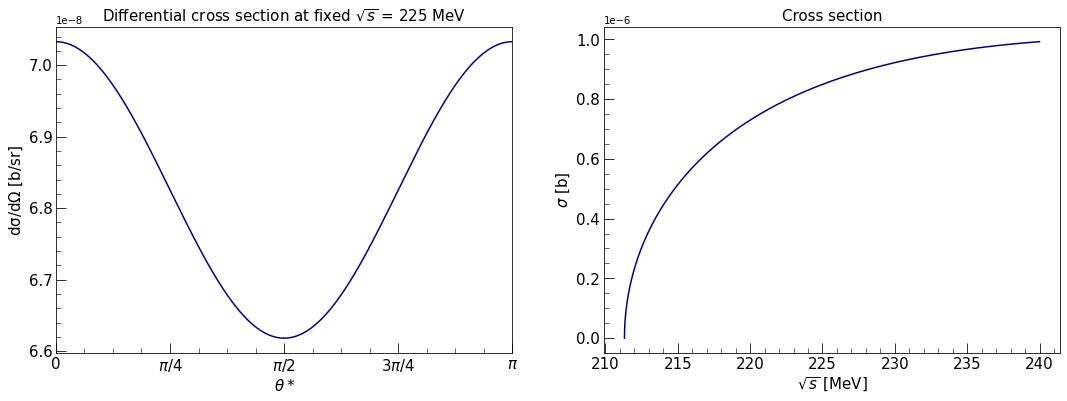

In [4]:
#plotting the results
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))

#creating the angle grid between 0 and pi 
theta = np.linspace(0,np.pi,N)

#set titles
ax[0].set_title('Differential cross section at fixed $\sqrt{s}$ = %i MeV'%sqr_s, size = 15)
ax[1].set_title('Cross section', size = 15)

#set labels
ax[0].set_xlabel('$\\theta*$', size = 15)
ax[0].set_ylabel(r'$\rm{d}\sigma$/$\rm{d}\Omega$ [b/sr]', size = 15)

ax[1].set_xlabel(r'$\sqrt{s}$ [MeV]', size = 15)
ax[1].set_ylabel(r'$\sigma$ [b]', size = 15)
ax[1].xaxis.set_major_locator(MultipleLocator(5.))

#setting x lables in rad for differential cross section plot
ax[0].set_xlim(0,np.pi)
ax[0].set_xticks([0,np.pi/4,np.pi/2,(3*np.pi)/4,np.pi],[0, '$\\pi/4$','$\\pi/2$','$3\\pi/4$','$\\pi$'])

#set x spacing for cross section plot
x = np.linspace(2*mu,240,N)

#plot 
ax[0].plot(theta,sigma_diff(s,theta)*conv_fact,  linestyle = '-', color = 'navy')
ax[1].plot(x,sigma(x**2)*conv_fact,  linestyle = '-', color = 'navy')


for ax in fig.get_axes():
    # plot settings                    
    ax.tick_params(axis = 'both', which = 'major', direction = 'in', length = 10, labelsize = 15)
    ax.tick_params(axis = 'both', which = 'minor', direction = 'in', length = 5)
    ax.minorticks_on()

plt.show()
#fig.savefig('figures/cross_section.pdf',dpi=200)

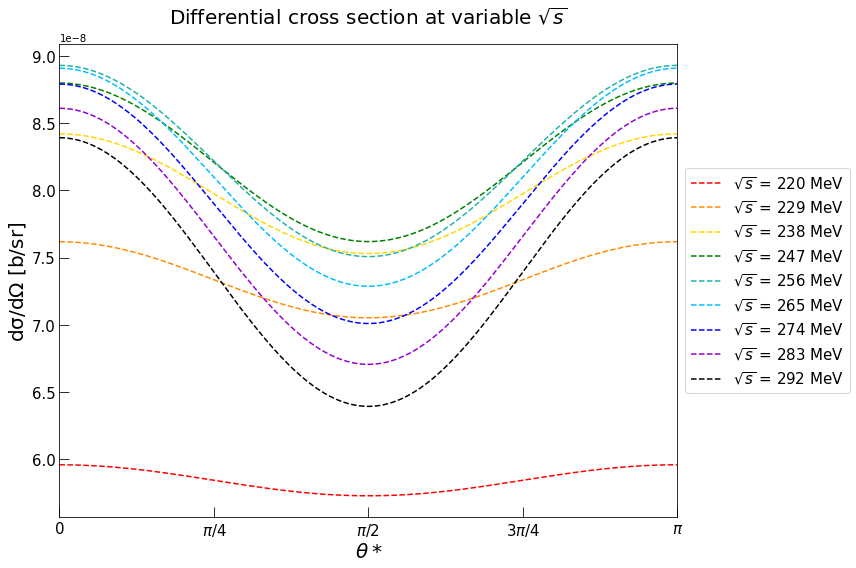

In [5]:
#plotting the results at variable s 
fig, ax = plt.subplots(1, figsize = (12,8))

#creating the angle grid between 0 and pi 
theta = np.linspace(0,np.pi,N)

colors = ['red', 'darkorange', 'gold', 'green', 'lightseagreen', 'deepskyblue', 'blue', 'darkviolet','black']

#range of s variable 
s_var = np.arange(220,300,9)

for i in range(0,9):
    ax.plot(theta, sigma_diff(s_var[i]**2,theta)*conv_fact,label = '$\sqrt{s}$ = %s MeV'%s_var[i], color = colors[i],ls='dashed')


#set title
ax.set_title('Differential cross section at variable $\\sqrt{s}$', size = 20,pad = 20)

#set labels
ax.set_xlabel('$\\theta*$', size = 20)
ax.set_ylabel(r'$\rm{d}\sigma$/$\rm{d}\Omega$ [b/sr]', size = 20)

#setting x lables in rad for differential cross section plot
ax.set_xticks([0,np.pi/4,np.pi/2,(3*np.pi)/4,np.pi],[0, '$\\pi/4$','$\\pi/2$','$3\\pi/4$','$\\pi$'])

#setting x range 
ax.set_xlim(0,np.pi)
ax.tick_params(axis = 'both', which = 'major', direction = 'in', length = 10, labelsize = 15)
ax.tick_params(axis = 'both', which = 'minor', direction = 'in', length = 5)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=15, ncol = 1)

fig.tight_layout()
#fig.savefig('figures/diff_sigma_s.pdf')
plt.show()



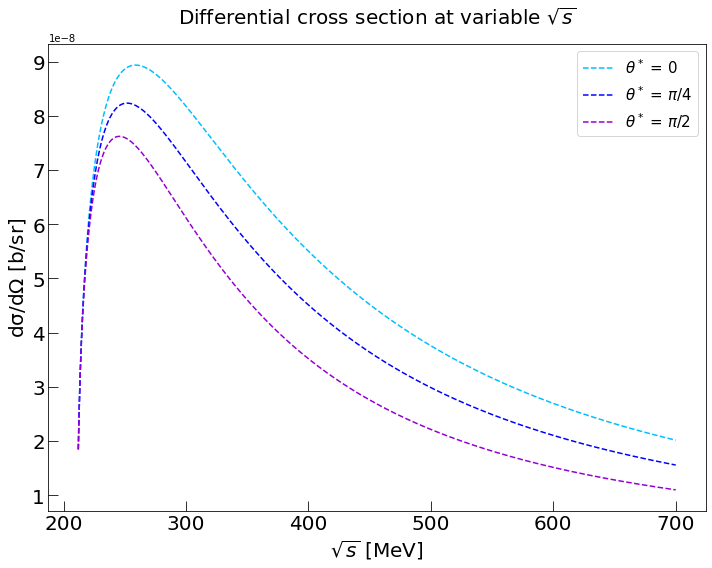

In [6]:
#plotting the results at variable s 
fig, ax = plt.subplots(1, figsize = (10,8))

#creating the angle grid between 0 and pi 
theta = np.linspace(0,np.pi,N)

colors = ['deepskyblue', 'blue', 'darkviolet']
labels = ['0','$\\pi/4$','$\\pi/2$']

s_var = np.linspace(212,700,1000)

angles = [0, np.pi/4, np.pi/2]

for i in range(3):
    globals()[f'y{i}'] = []

for i in range(3):
    for j in range(len(s_var)):
        globals()[f'y{i}'].append(conv_fact*sigma_diff(s_var[j]**2,angles[i]))

    ax.plot(s_var, globals()[f'y{i}'], color = colors[i], ls='dashed', label = '$\\theta^*$ = {}'.format(labels[i]))
  

#set title
ax.set_title('Differential cross section at variable $\\sqrt{s}$', size = 20,pad = 20)


#set labels
ax.set_xlabel('$\\sqrt{s}$ [MeV]', size = 20)
ax.set_ylabel(r'$\rm{d}\sigma$/$\rm{d}\Omega$ [b/sr]', size = 20)


ax.tick_params(axis = 'both', which = 'major', direction = 'in', length = 10, labelsize = 20)
ax.tick_params(axis = 'both', which = 'minor', direction = 'in', length = 5)
ax.legend(loc='best', fontsize=15, ncol = 1)

fig.tight_layout()
#fig.savefig('figures/diff_sigma_fixedtheta.pdf')
plt.show()



## 1.2 Angular distribution ($\theta^*$) (CM frame) <a class="anchor" id="Subsection.1"></a>
<div style="text-align: right"><a href="#Section.index">Return to index</a></div>

Since we now need to produce and plot the angular distribution of the scattering process, we find the CDF of the distribution itself and we invert it, using the **inverse transform method**. 

While the CDF can be computed by integrating analytically the function of the distribution, the inversion can not be obtained in an analytical way, so that we choose to use the interpolation method. By firstly generating a sufficient number of points following a uniform distribution in [0,1] and then using the inverse of our distribution, we can obtain the samples we need.

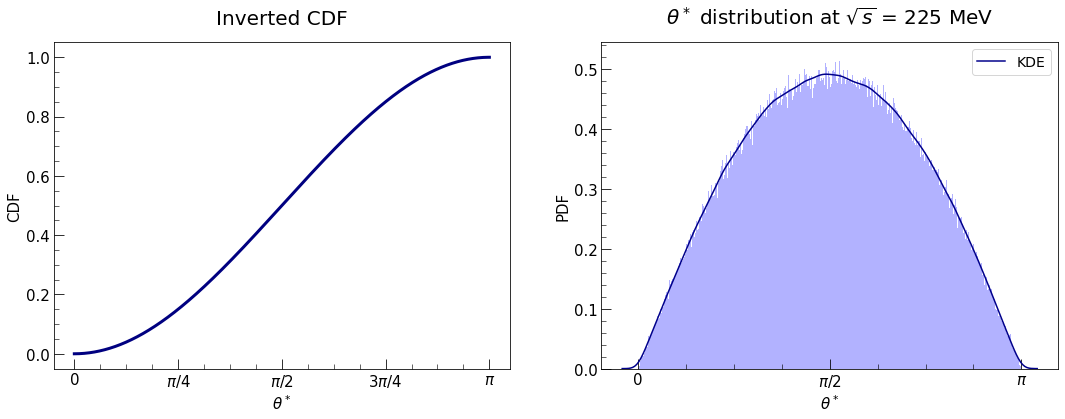

In [7]:
N = 10**6
samples = np.random.uniform(size= N)

#Compute inverse CDF of g(theta*) by interpolation
CDF_inversion = interp1d(g_cdf(225**2, theta), theta, fill_value='extrapolate') 

#histogram plot
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))

ax[0].plot(theta,g_cdf(s,theta),color = 'navy',linewidth = 3)

sns.distplot(CDF_inversion(samples), ax = ax[1],
             kde = True, 
             kde_kws  = {'label': 'KDE',  'color': 'darkblue'},
             hist_kws = { 'color': 'blue', 'alpha': 0.3,'linewidth': 1,  'histtype':'barstacked'},
             bins = int(np.sqrt(N)))

#np.savetxt('angular_distribution_CM.txt', CDF_inversion(samples)) # save to file


#setting labels, title and ticks
ax[0].set_title('Inverted CDF', pad = 18, fontsize=20)
ax[0].set_xlabel('$\\theta^*$',fontsize = 15)
ax[0].set_ylabel('CDF',fontsize = 15)
ax[0].set_xticks([0,np.pi/4,np.pi/2,(3*np.pi)/4,np.pi],[0, '$\\pi/4$','$\\pi/2$','$3\\pi/4$','$\\pi$'])


ax[1].set_title(r'$\theta^*$ distribution at $\sqrt{s}$ = %i MeV'%sqr_s, pad = 18, fontsize=20)
ax[1].set_xticks([0,np.pi/2,np.pi],['0','$\\pi/2$','$\\pi$'],fontsize = 10 )
ax[1].set_xlabel('$\\theta^*$',fontsize = 15)
ax[1].set_ylabel('PDF',fontsize = 15)

#plot legend 
ax[1].legend(loc = 'best', fontsize = 14)

for ax in fig.get_axes():
    # plot settings                    
    ax.tick_params(axis = 'both', which = 'major', direction = 'in', length = 10, labelsize = 15)
    ax.tick_params(axis = 'both', which = 'minor', direction = 'in', length = 5)
    ax.minorticks_on()

plt.show()
#fig.savefig('figures/theta_dist_CDF.pdf',dpi=200)

## 1.3 Momenta distribution (CM frame) <a class="anchor" id="Subsection.1"></a>
<div style="text-align: right"><a href="#Section.index">Return to index</a></div>


According to the cilindrical symmetry of the process, we expect that the momentum components along y-axis and z-axis will behave the same. 
Moreover, the muons will be produced with supplementary angles and same momentum components distributions. 

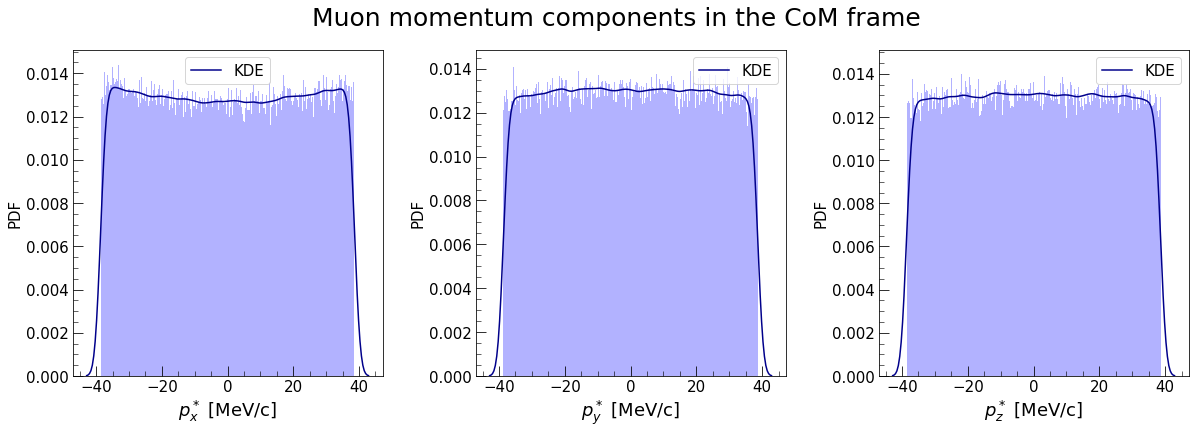

In [8]:
# Momenta plot in CM
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,6))

#set title
fig.suptitle(' Muon momentum components in the CoM frame',fontsize = 25)

#set labels 
ax[0].set_xlabel('$p_x^*$ [MeV/c]', size = 18)
ax[0].set_ylabel('PDF', size = 15)

ax[1].set_xlabel('$p_y^*$ [MeV/c]', size = 18)
ax[1].set_ylabel('PDF', size = 15)

ax[2].set_xlabel('$p_z^*$ [MeV/c]', size = 18)
ax[2].set_ylabel('PDF', size = 15)


#set projections of momenta
phi_ang   = np.random.uniform(0, 2 * np.pi, size=N)
px = norm(s) * np.cos(CDF_inversion(samples)) 
py = norm(s) * np.sin(CDF_inversion(samples)) * np.cos(phi_ang)
pz = norm(s) * np.sin(CDF_inversion(samples)) * np.sin(phi_ang)

#plot 
sns.distplot(px, ax = ax[0],
             kde = True, 
             kde_kws  = {'label': 'KDE',  'color': 'darkblue'},
             hist_kws = { 'color': 'blue', 'alpha': 0.3,'linewidth': 1,  'histtype':'barstacked'},
             bins = int(np.sqrt(N)))
sns.distplot(py, ax = ax[1],
             kde = True, 
             kde_kws  = {'label': 'KDE',  'color': 'darkblue'},
             hist_kws = { 'color': 'blue', 'alpha': 0.3,'linewidth': 1,  'histtype':'barstacked'},
             bins = int(np.sqrt(N)))
sns.distplot(pz, ax = ax[2],
             kde = True, 
             kde_kws  = {'label': 'KDE',  'color': 'darkblue'},
             hist_kws = { 'color': 'blue', 'alpha': 0.3,'linewidth': 1,  'histtype':'barstacked'},
             bins = int(np.sqrt(N)))


for ax in fig.get_axes():
    # plot settings                    
    ax.tick_params(axis = 'both', which = 'major', direction = 'in', length = 10, labelsize = 15)
    ax.tick_params(axis = 'both', which = 'minor', direction = 'in', length = 5)
    ax.minorticks_on()
    ax.legend(loc='best', fontsize=15)

plt.subplots_adjust(wspace=.30)
plt.show()
#fig.savefig('figures/momenta_CM.pdf',dpi=200)

***

- Boost muons four-momenta in the laboratory frame, i.e. in the frame where the electron is at rest and the positron has enough energy to initiate the process.
***

## 1.4 Boost to the laboratory frame <a class="anchor" id="Subsection.1"></a>
<div style="text-align: right"><a href="#Section.index">Return to index</a></div>

By using the previously justified formulas, we can find the coordinates and the angles in the laboratory frame, starting from the same values obtained for the center of mass frame. 

In [9]:
#boost all the quantities to the laboratory frame
(E_lab, px_lab) = boost_coordinates(s,px)
tan_theta_lab_m1 = tan_boost_ang(CDF_inversion(samples))
tan_theta_lab_m2 = tan_boost_ang((-1)*CDF_inversion(samples))

theta_lab_m1 = np.arctan(tan_theta_lab_m1)
theta_lab_m2 = np.arctan(tan_theta_lab_m2)

## 1.5 Angular distribution ($\theta$) (Lab. frame)<a class="anchor" id="Subsection.1"></a>
<div style="text-align: right"><a href="#Section.index">Return to index</a></div>

In the following plots we can easily notice that, since the angles of productions are quite small, plotting $tan(\theta)$ or $\theta$ itself does not give any visible difference.

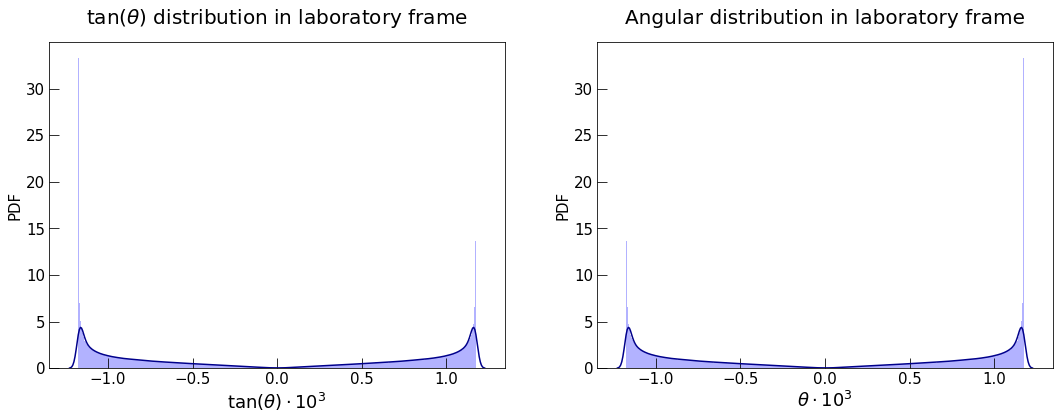

In [10]:
#plotting the angular distribution
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))

#setting title and labels
ax[0].set_title('$\\tan(\\theta)$ distribution in laboratory frame', pad = 18, fontsize=20)
ax[0].set_xlabel('$\\tan(\\theta) \cdot 10^3$', fontsize=18)
ax[0].set_ylabel('PDF', size = 15)
ax[0].tick_params(axis = 'both', which = 'major', direction = 'in', length = 10, labelsize = 15)
ax[0].xaxis.set_major_locator(MultipleLocator(0.5))


ax[1].set_title('Angular distribution in laboratory frame', pad = 18, fontsize=20)
ax[1].set_xlabel('$\\theta \cdot 10^3$', fontsize=18)
ax[1].set_ylabel('PDF', size = 15)
ax[1].tick_params(axis = 'both', which = 'major', direction = 'in', length = 10, labelsize = 15)
ax[1].xaxis.set_major_locator(MultipleLocator(0.5))


#plot 
sns.distplot(tan_theta_lab_m1*1000, ax = ax[0],
             kde = True, 
             kde_kws  = {'label': 'KDE',  'color': 'darkblue'},
             hist_kws = { 'color': 'blue', 'alpha': 0.3,'linewidth': 1,  'histtype':'barstacked'},
             bins = int(np.sqrt(N)))
sns.distplot(tan_theta_lab_m2*1000, ax = ax[0],
             kde = True, 
             kde_kws  = {'label': 'KDE',  'color': 'darkblue'},
             hist_kws = { 'color': 'blue', 'alpha': 0.3,'linewidth': 1,  'histtype':'barstacked'},
             bins = int(np.sqrt(N)))

sns.distplot(theta_lab_m1*1000, ax = ax[1],
             kde = True, 
             kde_kws  = {'label': 'KDE',  'color': 'darkblue'},
             hist_kws = { 'color': 'blue', 'alpha': 0.3,'linewidth': 1,  'histtype':'barstacked'},
             bins = int(np.sqrt(N)))
sns.distplot(theta_lab_m2*1000, ax = ax[1],
             kde = True, 
             kde_kws  = {'label': 'KDE',  'color': 'darkblue'},
             hist_kws = { 'color': 'blue', 'alpha': 0.3,'linewidth': 1,  'histtype':'barstacked'},
             bins = int(np.sqrt(N)))


plt.show()
fig.savefig('figures/angular_LAB.pdf',dpi=200)

## 1.6 Momentum and energy distribution (Lab. frame)<a class="anchor" id="Subsection.1"></a>
<div style="text-align: right"><a href="#Section.index">Return to index</a></div>


Since the boost is applied along the x-axis, the other momentum components ($p_y, p_z$) are left unmodified and it is not interesting to replot them. 

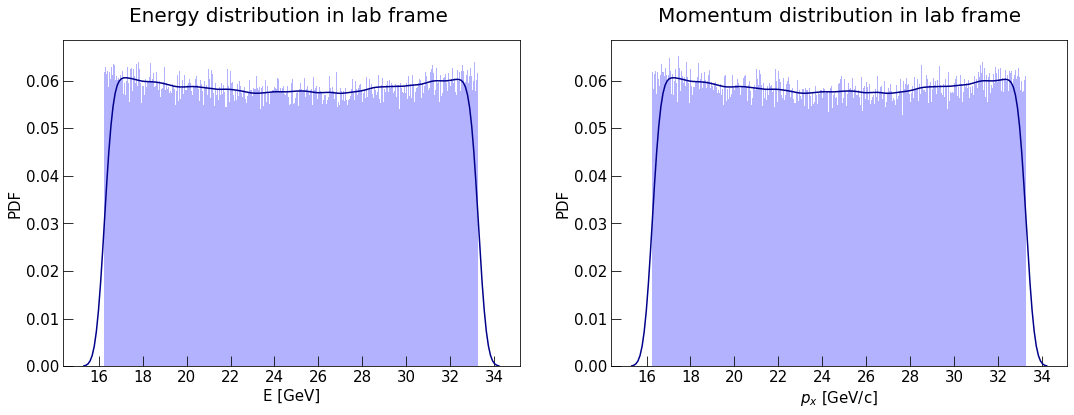

In [11]:
#plotting the momentum and energy distribution

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(18,6))

#setting title and labels
ax[0].set_title('Energy distribution in lab frame ', pad = 18, fontsize=20)
ax[0].set_xlabel('E [GeV]', fontsize=15)
ax[0].set_ylabel('PDF', size = 15)
ax[0].tick_params(axis = 'both', which = 'major', direction = 'in', length = 10, labelsize = 15)
ax[0].xaxis.set_major_locator(MultipleLocator(2))

ax[1].set_title('Momentum distribution in lab frame', pad = 18, fontsize=20)
ax[1].set_xlabel('$p_x$ [GeV/c]', fontsize=15)
ax[1].set_ylabel('PDF', size = 15)
ax[1].tick_params(axis = 'both', which = 'major', direction = 'in', length = 10, labelsize = 15)
ax[1].xaxis.set_major_locator(MultipleLocator(2))

#plotting histograms
sns.distplot(E_lab/1000, ax = ax[0],
             kde = True, 
             kde_kws  = {'label': 'KDE',  'color': 'darkblue'},
             hist_kws = { 'color': 'blue', 'alpha': 0.3,'linewidth': 1,  'histtype':'barstacked'},
             bins = int(np.sqrt(N)))
sns.distplot(px_lab/1000, ax = ax[1],
             kde = True, 
             kde_kws  = {'label': 'KDE',  'color': 'darkblue'},
             hist_kws = { 'color': 'blue', 'alpha': 0.3,'linewidth': 1,  'histtype':'barstacked'},
             bins = int(np.sqrt(N)))

plt.show()
#fig.savefig('figures/energy_mom_LAB.pdf',dpi=200)

***
- Write a Monte Carlo simulation that generates scattering events following the distributions found analytically.
- Produce a synthetic dataset of about $N=10^5$ (or more) events. Events should be expressed as rows in a file with columns representing the muons coordinates.

***

# 2. Montecarlo with monochromatic beam <a class="anchor" id="Section.2"></a>
<div style="text-align: right"><a href="#Section.index">Return to index</a></div>

The first simulation of the scattering process is based on a monochromatic positron beam, i.e. it has the following characteristics:
- we assume its transversal section to be point-like;
- all the beam particles have the same energy.

## INVERSE SAMPLING
In order to sample $\theta$ distributed according to the differential cross section, we will use the inverse transform method. 
Since we know the analytic form of CDF of the angular distribution in the CoM frame $g(\theta^*)$, this approach can be applied and 
leads to better performances. The distribution $h(\varphi^*)$ is infact uniform in the interval [0,$2\pi$]. Namely we have:

$$
g(\theta^*) = \frac{2\pi \sin(\theta^*)}{\sigma^*} \cdot \frac{\mathrm{d}\sigma^*}{\mathrm{d}\Omega^*} \quad \quad \text{and} \quad \quad h(\varphi^*) = \frac{1}{2\pi}

$$

The CDF is computed through the following: 

$$ \begin{align}
\text{CDF}[ g(\theta^*)]=  \int_0^{\theta^*} g(\theta^*)  \mathrm{d}\theta^*  
= \int_0^{\theta^*} \frac{2\pi \sin(\theta^*)}{\sigma} \cdot \frac{\alpha^2}{4s} \left(1- \frac{4 m_\mu^2}{s}\right)^{1/2} \left(1- \frac{4 m_e^2}{s}\right)^{-1/2}\left[ 1+ \frac{4}{s} (m_e^2 + m_\mu^2) + \left(1-\frac{4 m_e^2}{s}\right)\left(1-\frac{4 m_\mu^2}{s}\right)\cos^2\theta^*\right]  \\ = 
\frac{2\pi}{\sigma} \frac{\alpha^2}{4s} \left(1- \frac{4 m_\mu^2}{s}\right)^{1/2} \left(1- \frac{4 m_e^2}{s}\right)^{-1/2}
    \cdot \left\{\left[1+ \frac{4}{s} (m_e^2 + m_\mu^2)\right] (1 - \cos\theta^*) + \frac{1}{3}\left(1-\frac{4 m_e^2}{s}\right)\left(1-\frac{4 m_\mu^2}{s}\right)(1 - \cos^3\theta^*)\right\} \tag{0.1}
\end{align} $$

To generate the events:

$a_i$ random uniform in [0,1] $\implies$ CDF[$g(\theta^*)]^{-1}$($a_i$) =$\theta^*_i \\$ 
$b_i$ random uniform in [0,$2\pi$] $\implies$ CDF[$h(\varphi^*)]^{-1}$($b_i$) =$\varphi^*_i $

The inverse of the CDF is computed by interpolation through different methods available in the scipy library, i.e. ``UnivariateSpline``, ``InterpolatedUnivariateSpline`` and ``interp1d``.


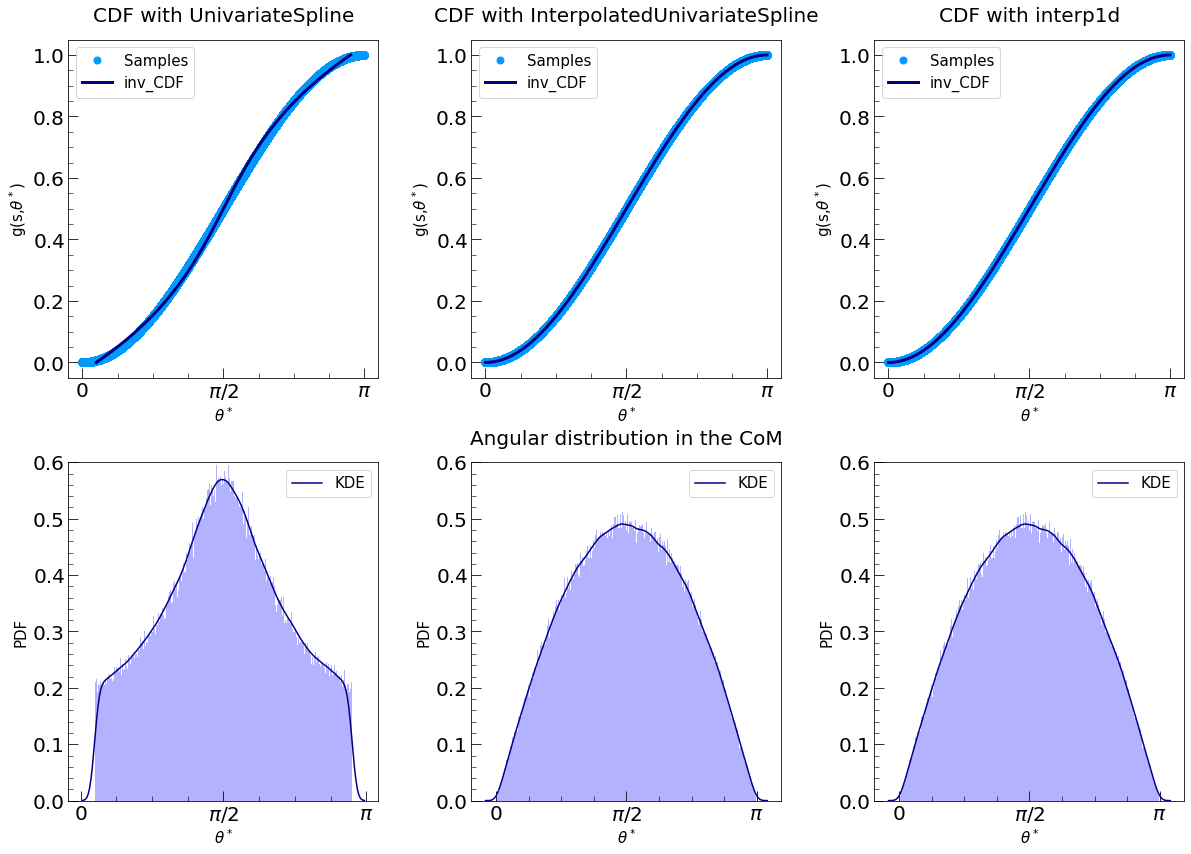

In [12]:
fig, ax = plt.subplots(2,3, figsize = (20,14))

# Angles in the CoM frame on which we sample the inverse CDF
theta_star = np.linspace(0, np.pi, N)

s = sqr_s**2 

# three version of inverse CDF sampling
inv_cdf1 = UnivariateSpline(g_cdf(s,theta_star),theta_star, ext=0)
inv_cdf2 = InterpolatedUnivariateSpline(g_cdf(s,theta_star),theta_star, ext=0)
inv_cdf3 = interp1d(g_cdf(s, theta_star), theta_star, fill_value='extrapolate') 
#'extrapolate' is needed for the points at z=0,1, which are 'slightly' outside of the samples
    
# Sample some angles
num_samples = N
unif_samples = np.random.uniform(size=num_samples)
samples_sorted = np.sort(unif_samples)

phis = np.random.uniform(0, 2 * np.pi, size=num_samples)

#same plot on each ax of the points
for i in range(3):
    ax[0][i].plot(theta_star,g_cdf(s,theta_star),'o',markersize= 7,color = '#009AFF',label='Samples')
    ax[0][i].set_ylabel('g(s,$\\theta^*$)',fontsize = 15)   
    ax[0][i].set_xlabel('$\\theta^*$',fontsize = 15)
    ax[0][i].set_xticks([0,np.pi/2,np.pi],['0','$\\pi/2$','$\\pi$'],fontsize = 10 )

    ax[1][i].set_ylim(0,0.6)
    ax[1][i].set_xticks([0,np.pi/2,np.pi],['0','$\\pi/2$','$\\pi$'],fontsize = 10 )
    ax[1][i].set_xlabel('$\\theta^*$',fontsize = 15)
    ax[1][i].set_ylabel('PDF',fontsize = 15)
    

ax[1][1].set_title('Angular distribution in the CoM', pad = 18, fontsize=20)


### UnivariateSpline ###
ax[0][0].set_title('CDF with UnivariateSpline', pad = 18, fontsize=20)
ax[0][0].plot(inv_cdf1(samples_sorted),samples_sorted,color = 'navy',label = 'inv_CDF',linewidth = 3) 
sns.distplot(inv_cdf1(samples_sorted), ax = ax[1][0],
                kde = True, 
                kde_kws  = {'label': 'KDE',  'color': 'darkblue'},
                hist_kws = { 'color': 'blue', 'alpha': 0.3,'linewidth': 1,  'histtype':'barstacked'}, 
                bins = int(np.sqrt(N))
                )


### InterpolatedUnivariateSpline ###
ax[0][1].set_title('CDF with InterpolatedUnivariateSpline', pad = 18, fontsize=20)
ax[0][1].plot(inv_cdf2(samples_sorted),samples_sorted,color = 'navy',label = 'inv_CDF',linewidth = 3) 
sns.distplot(inv_cdf2(samples_sorted), ax = ax[1][1],
                kde = True, 
                kde_kws  = {'label': 'KDE',  'color': 'darkblue'},
                hist_kws = { 'color': 'blue', 'alpha': 0.3,'linewidth': 1,  'histtype':'barstacked'}, 
                bins = int(np.sqrt(N))
                )

### interp1d ###
ax[0][2].set_title('CDF with interp1d', pad = 18, fontsize=20)
ax[0][2].plot(inv_cdf3(samples_sorted),samples_sorted,color = 'navy',label = 'inv_CDF',linewidth = 3) 
sns.distplot(inv_cdf3(samples_sorted), ax = ax[1][2],
                kde = True, 
                kde_kws  = {'label': 'KDE',  'color': 'darkblue'},
                hist_kws = { 'color': 'blue', 'alpha': 0.3,'linewidth': 1,  'histtype':'barstacked'}, 
                bins = int(np.sqrt(N))
                )
                
for ax in fig.get_axes():
    # plot settings                    
    ax.tick_params(axis = 'both', which = 'major', direction = 'in', length = 10, labelsize = 20)
    ax.tick_params(axis = 'both', which = 'minor', direction = 'in', length = 5)
    ax.minorticks_on()
    ax.legend(loc='best', fontsize=15)

plt.subplots_adjust(hspace=.25,wspace=.3)
plt.show()
fig.savefig('figures/CDF_methods.png')


Different interpolating functions lead to different distribution: in particular the ``InterpolatedUnivariateSpline``method is not able to fit the extremes providing a wrong angular distribution. 
We then decide to use the ``interp1d`` method. 

In order to generate the scattering events we definie a routine that is implemented in the function `generate_beam`, which returns the two muons 3-momenta in the laboratory frame. 

In [13]:
def generate_beam(sqr_s, bunch_size = 10**5):
    '''
    Function that generates one bunch of scattering events
    
    Parameters:

    sqr_s : Center of mass energy (sqrt(s)) in MeV (must be > 2 mu)
           
    bunch_size : Number of events in one bunch


    Returns: 
    ndarray of size (bunch_size, 6)
    Each row is one event, and contains the components of the 3-momenta (in the laboratory frame)
    of the muon-antimuon pair, in [MeV/c]
     
    '''
    
    assert sqr_s > 2 * mu, 'There is not enough energy for muon pair production'
    s = sqr_s**2 

    pnorm = norm(s) # Norm of muon 3-momentum in CM
    
    # Compute inverse CDF of g(theta*) by interpolation 
    theta_star = np.linspace(0, np.pi, N)
    inv_cdf = interp1d(g_cdf(s, theta_star), theta_star, fill_value='extrapolate')

    # Sample angles
    num_samples = N
    unif_samples = np.random.uniform(size=bunch_size)

    phis = np.random.uniform(0, 2 * np.pi, size=bunch_size)
    thetas = inv_cdf(unif_samples)
    
    
    # Compute cartesian components of 3-vector
    px_cm = pnorm * np.cos(thetas)
    py_cm = pnorm * np.sin(thetas) * np.cos(phis)
    pz_cm = pnorm * np.sin(thetas) * np.sin(phis)


    _,px1 = boost_coordinates(s, px_cm)  # px for first muon
    _,px2 = boost_coordinates(s, -px_cm) # px for second muon
    # py and pz are orthogonal to boost axis, and so they remain the same
    
    return np.stack((px1, py_cm, pz_cm, px2, -py_cm, -pz_cm), axis=1)    



In [14]:
# generate events 
events = generate_beam(225, 10**6)
# save events in DataFrame 
df_monochromatic = pd.DataFrame(events, columns = ['$px_{\mu_1}$','$py_{\mu_1}$','$pz_{\mu_1}$','$px_{\mu_2}$','$py_{\mu_2}$','$pz_{\mu_2}$'])

# save events in txt file and dataframe 
#np.savetxt("Momenta_monochromatic.txt", events) # save to file
df_monochromatic = pd.DataFrame(events, columns = ['$px_{\mu_1}$','$py_{\mu_1}$','$pz_{\mu_1}$','$px_{\mu_2}$','$py_{\mu_2}$','$pz_{\mu_2}$'])
#df_monochromatic.to_csv('Events.csv')
df_monochromatic

,$px_{\mu_1}$,$py_{\mu_1}$,$pz_{\mu_1}$,$px_{\mu_2}$,$py_{\mu_2}$,$pz_{\mu_2}$
0,23837.535456,-10.286799,36.998649,25697.280377,10.286799,-36.998649
1,26222.123547,38.019238,-1.853235,23312.692285,-38.019238,1.853235
2,25310.163648,-2.100184,-38.497651,24224.652184,2.100184,38.497651
3,26686.406468,-37.119377,-6.223518,22848.409364,37.119377,6.223518
4,17410.397428,5.955733,18.449494,32124.418404,-5.955733,-18.449494
...,...,...,...,...,...,...
999995,30355.359113,28.249145,7.093281,19179.456719,-28.249145,-7.093281
999996,25006.430848,11.235707,36.947772,24528.384984,-11.235707,-36.947772
999997,19856.421609,30.339762,-8.629348,29678.394224,-30.339762,8.629348
999998,17344.919458,-7.130779,-17.465412,32189.896374,7.130779,17.465412


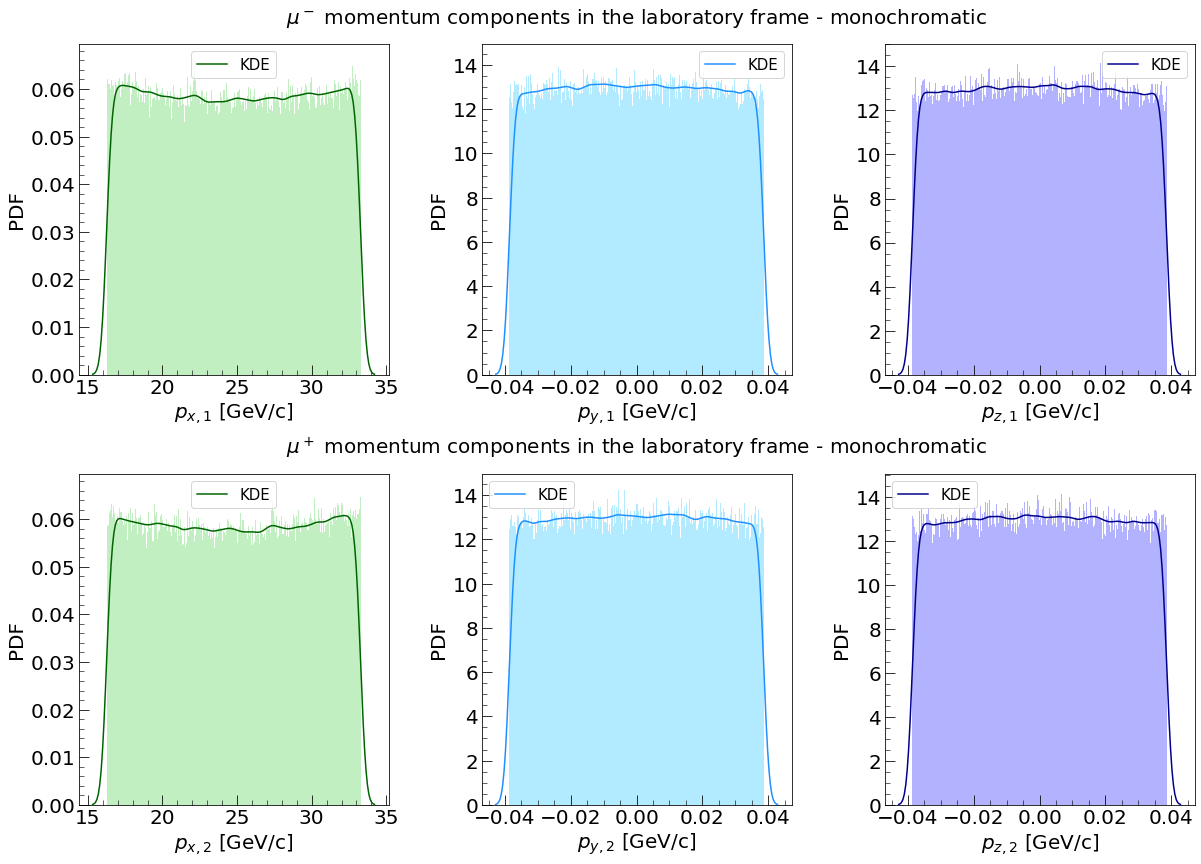

In [15]:
fig, ax = plt.subplots(2,3, figsize = (20,14))

# plotting momentum components distribution in the LAB frame


### MUON 1 ###
# px
sns.distplot(df_monochromatic['$px_{\mu_1}$']/1000,
             ax = ax[0][0],
             bins = int(np.sqrt(N)),
             kde = True,
             kde_kws  = {'color': 'darkgreen',   'label': 'KDE'},
             hist_kws = {'color': 'limegreen', 'alpha': 0.3, 'linewidth': 1, 'histtype':'barstacked'}
             )

            
# py
sns.distplot(df_monochromatic['$py_{\mu_1}$']/1000,
             ax = ax[0][1],
             bins = int(np.sqrt(N)),
             kde = True,
             kde_kws  = {'color': 'dodgerblue',   'label': 'KDE'},
             hist_kws = {'color': 'deepskyblue', 'alpha': 0.3, 'linewidth': 1, 'histtype':'barstacked'}
             )
            
# pz
sns.distplot(df_monochromatic['$pz_{\mu_1}$']/1000,
             ax = ax[0][2],
             bins = int(np.sqrt(N)),
             kde = True,
             kde_kws  = {'color': 'darkblue',   'label': 'KDE'},
             hist_kws = {'color': 'blue', 'alpha': 0.3, 'linewidth': 1, 'histtype':'barstacked'}
            )


ax[0][0].set_xlabel(r'$p_{x,1}$ [GeV/c]',fontsize = 20)
ax[0][1].set_xlabel(r'$p_{y,1}$ [GeV/c]',fontsize = 20)
ax[0][2].set_xlabel(r'$p_{z,1}$ [GeV/c]',fontsize = 20)

ax[0][1].set_title('$\mu^-$ momentum components in the laboratory frame - monochromatic',fontsize = 20,pad = 20)


### MUON 2 ###
# px
sns.distplot(df_monochromatic['$px_{\mu_2}$']/1000,
             ax = ax[1][0],
             bins = int(np.sqrt(N)),
             kde = True,
             kde_kws  = {'color': 'darkgreen',   'label': 'KDE'},
             hist_kws = {'color': 'limegreen', 'alpha': 0.3, 'linewidth': 1, 'histtype':'barstacked'}
             )
            
# py
sns.distplot(df_monochromatic['$py_{\mu_2}$']/1000,
             ax = ax[1][1],
             bins = int(np.sqrt(N)),
             kde = True,
             kde_kws = {'color':'dodgerblue','label':'KDE'},
             hist_kws = {'color': 'deepskyblue', 'alpha': 0.3, 'linewidth': 1, 'histtype':'barstacked'}
             )
            
# pz
sns.distplot(df_monochromatic['$pz_{\mu_2}$']/1000,
             ax = ax[1][2],
             bins = int(np.sqrt(N)),
             kde = True,
             kde_kws  = {'color': 'darkblue', 'label':'KDE'},
             hist_kws = {'color': 'blue', 'alpha': 0.3, 'linewidth': 1, 'histtype':'barstacked'}
            )


ax[1][0].set_xlabel(r'$p_{x,2}$ [GeV/c]',fontsize = 20)
ax[1][1].set_xlabel(r'$p_{y,2}$ [GeV/c]',fontsize = 20)
ax[1][2].set_xlabel(r'$p_{z,2}$ [GeV/c]',fontsize = 20)

ax[1][1].set_title('$\mu^+$ momentum components in the laboratory frame - monochromatic',fontsize = 20, pad = 20)

for ax in fig.get_axes():
    # plot settings   
    ax.set_ylabel('PDF',fontsize = 20)                   
    ax.tick_params(axis = 'both', which = 'major', direction = 'in', length = 10, labelsize = 20)
    ax.tick_params(axis = 'both', which = 'minor', direction = 'in', length = 5)
    ax.minorticks_on()
    ax.legend(loc='best', fontsize=15, ncol = 2)


plt.subplots_adjust(hspace=.3,wspace=.3)
plt.show()
#fig.savefig('figures/momentum_mono_lab.png')



The momentum y and z components show a uniform distribution, centered in zero, as expected. On the other hand the x component distribution presents a negative concavity
with peaks at the extremes of the interval. In order to analyze how this distribution changes according to the inveriant mass, we generate events with 
$\sqrt{s}$ = $2m_{\mu} + \epsilon$, where $\epsilon$ is a quantity that will be varied in a certain range.

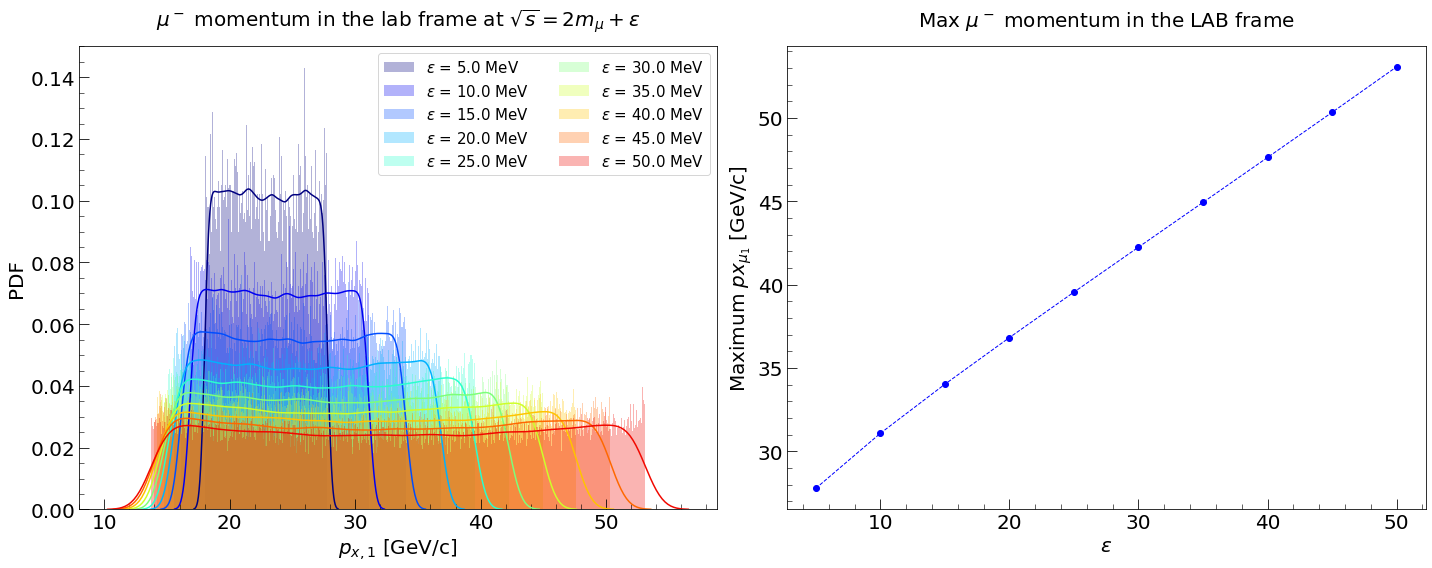

In [16]:
### P_x distribution in function of available energy ###
epsilon = 0.1

jet = plt.cm.jet
colors = jet(np.linspace(0, 1, 11))

max_p = []
epsilon = [5*i for i in range(1,11)]
for i in range(0,10):
    sqr_s = 2*mu + epsilon[i]
    events = generate_beam(sqr_s, 10**5)
    globals()[f'df{i}'] = pd.DataFrame(events, columns = ['$px_{\mu_1}$','$py_{\mu_1}$','$pz_{\mu_1}$','$px_{\mu_2}$','$py_{\mu_2}$','$pz_{\mu_2}$'])
    max_p.append(np.max(globals()[f'df{i}']['$px_{\mu_1}$'])/1000)


fig, ax = plt.subplots(1, 2, figsize=(20,8))

# plotting momentum components distribution in the LAB frame

for i in range(0,10):
    sns.distplot(globals()[f'df{i}']['$px_{\mu_1}$']/1000,
                ax = ax[0],
                bins = int(np.sqrt(N)),
                kde = True,
                kde_kws  = {'color': colors[i]},
                hist_kws = { 'alpha': 0.3, 'linewidth': 1, 'histtype':'barstacked', 
                'label': '$\epsilon$ = {:.1f} MeV'.format(epsilon[i]), 'color': colors[i]}
                )


ax[1].plot(epsilon,max_p, lw=1,ls='dashed', marker = 'o', color = 'blue')
ax[1].set_xlabel('$\epsilon$',fontsize = 20)
ax[1].set_ylabel('Maximum $px_{\mu_1}$ [GeV/c]',fontsize = 20) 
ax[1].set_title('Max $\mu^-$ momentum in the LAB frame',fontsize = 20,pad = 20)


ax[0].set_xlabel(r'$p_{x,1}$ [GeV/c]',fontsize = 20)
ax[0].set_title('$\mu^-$ momentum in the lab frame at $\sqrt{s}=2m_{\mu}+\epsilon$',fontsize = 20,pad = 20)
ax[0].set_ylabel('PDF',fontsize = 20)  
ax[0].legend(loc='best', fontsize=15, ncol = 2)

for ax in fig.get_axes():
    # plot settings                  
    ax.tick_params(axis = 'both', which = 'major', direction = 'in', length = 10, labelsize = 20)
    ax.tick_params(axis = 'both', which = 'minor', direction = 'in', length = 5)
    ax.minorticks_on()

fig.tight_layout()
#fig.savefig('figures/momentum_epsilon.pdf')
plt.show()

In [17]:
### P_x distribution in function of available energy ###
epsilon = 0.1

jet = plt.cm.jet
colors = jet(np.linspace(0, 1, 11))

max_p = []
epsilon = [100*i for i in range(1,11)]
for i in range(0,10):
    sqr_s = 2*mu + epsilon[i]
    events = generate_beam(sqr_s, 10**5)
    globals()[f'df{i}'] = pd.DataFrame(events, columns = ['$px_{\mu_1}$','$py_{\mu_1}$','$pz_{\mu_1}$','$px_{\mu_2}$','$py_{\mu_2}$','$pz_{\mu_2}$'])
    max_p.append(np.max(globals()[f'df{i}']['$px_{\mu_1}$'])/1000)

fig, ax = plt.subplots(1, 2, figsize=(20,8))

# plotting momentum components distribution in the LAB frame

for i in range(0,10):
    sns.distplot(globals()[f'df{i}']['$px_{\mu_1}$']/1000,
                ax = ax[0],
                bins = int(np.sqrt(N)),
                kde = True,
                kde_kws  = {'color': colors[i]},
                hist_kws = { 'alpha': 0.3, 'linewidth': 1, 'histtype':'barstacked', 'label': '$\epsilon$ = {:.1f} MeV/c$^2$'.format(epsilon[i]), 'color': colors[i]}
                )


ax[1].plot(epsilon,max_p, lw=1,ls='dashed', marker = 'o', color = 'blue')
ax[1].set_xlabel('$\epsilon$',fontsize = 24)
ax[1].set_ylabel('Maximum $px_{\mu_1}$ [GeV/c]',fontsize = 20) 
ax[1].set_title('Max $\mu_1$ momentum in the LAB frame',fontsize = 25,pad = 20)



ax[0].set_xlabel(r'$p_{x,1}$ [GeV/c]',fontsize = 24)
ax[0].set_title('$\mu_1$ momentum in the LAB frame, $\sqrt{s}=2m_{\mu}+\epsilon$',fontsize = 25,pad = 20)
ax[0].set_ylabel('PDF',fontsize = 20)  
ax[0].legend(loc='best', fontsize=15, ncol = 2)

for ax in fig.get_axes():
    # plot settings                  
    ax.tick_params(axis = 'both', which = 'major', direction = 'in', length = 10, labelsize = 20)
    ax.tick_params(axis = 'both', which = 'minor', direction = 'in', length = 5)
    ax.minorticks_on()
    

fig.tight_layout()
plt.show()

KeyboardInterrupt: 

## REJECTION SAMPLING
We can carry out the MC simulation also by means of the **acceptance-rejection method**, performing
a uniformly random sampling of the 2D Cartesian graph and keeping the samples in the region under the graph of its density function.
In particular, we will compare the obtained angular distribution.

In [ ]:
N = 10**6

def hit_miss(dist,limits,bunch_size = 10**5):
    '''
    Function that generates one batch of scattering events using rejection sampling

    Parameters:
    dist : desired distribution
           
    bunch_size : Number of events in one batch

    limits : extremes in an array of four elements 

    Returns: 
    array of size (bunch_size)

    '''

    # extremes in u and v direction 
    u1 = limits[0] # minimum of sampling distribution
    u2 = limits[1] # maximum of sampling distribution

    u = np.random.uniform(u1,u2,bunch_size)

    lower = 0                        # accept-reject minimum for each point
    upper = np.max(dist(sqr_s**2,u)) # accept-reject maximum for each point 

    v = np.random.uniform(lower,upper,bunch_size)

    # accepted points 
    points = u[v <= dist(sqr_s**2,u)]

    return points 

In [ ]:
import time 
start = time.time()
theta_samples = hit_miss(ang,(0,np.pi),10**6)
end = time.time()

time_HM = round(end - start,3)

print('Execution time: ',time_HM, 'sec for ',N, 'iterations')
print('Accepted events ratio:', len(theta_samples)/N)

Execution time:  0.133 sec for  1000000 iterations
Accepted events ratio: 0.680548


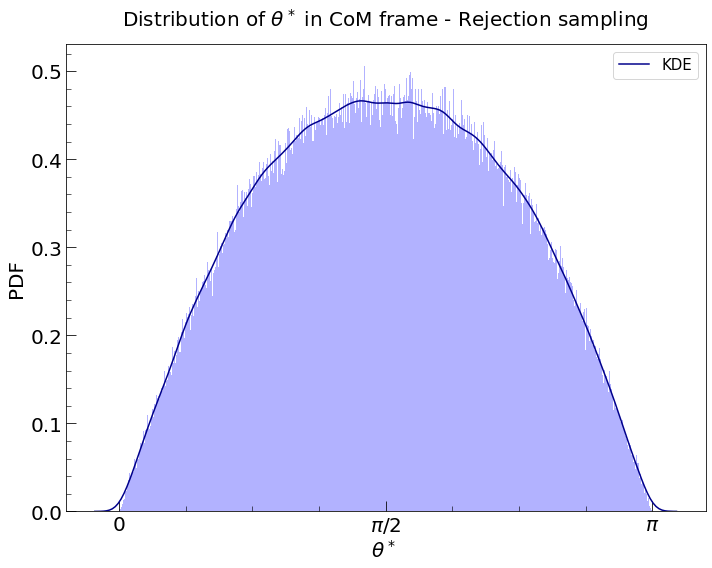

In [ ]:
# Plot angular distribution in CoM frame 

fig, ax = plt.subplots(1, figsize = (10,8))

sns.distplot(theta_samples, ax = ax,
             kde = True, 
             kde_kws  = {'label': 'KDE',  'color': 'darkblue'},
             hist_kws = { 'color': 'blue', 'alpha': 0.3,'linewidth': 1,  'histtype':'barstacked'},
             bins = int(np.sqrt(N)))

ax.set_title(r'Distribution of $\theta^*$ in CoM frame - Rejection sampling' ,fontsize = 20, pad = 18)
ax.set_xlabel(r'$\theta^*$ ',fontsize = 20)
ax.set_ylabel('PDF',fontsize = 20)               
ax.set_xticks([0,np.pi/2,np.pi],['0','$\\pi/2$','$\\pi$'],fontsize = 10 )

ax.tick_params(axis = 'both', which = 'major', direction = 'in', length = 10, labelsize = 20)
ax.tick_params(axis = 'both', which = 'minor', direction = 'in', length = 5)
ax.minorticks_on()

ax.legend(loc='best', fontsize=15, ncol = 1)

fig.tight_layout()
#fig.savefig('figures/angle_rejsampling.pdf')
plt.show()

We now want to compare the perfomances of the two methods mentioned above, in terms of execution time. Therefore,
we perform simulations varying the number of events to be generated.

In [ ]:
N_val = np.logspace(1,7,20, dtype=int)

times_CDF = []
times_HM = []

### First method - CDF inversion ###
for i in range(0,len(N_val)):
    theta = np.linspace(0, np.pi, N_val[i])
    samples = np.random.uniform(size = N_val[i])
    start = time.time()
    CDF_inversion = interp1d(g_cdf(225**2, theta), theta, fill_value='extrapolate') 
    thetas = CDF_inversion(samples)
    end = time.time()
    times_CDF.append(round(end - start,6))

### Second method - Rejection sampling ###
for i in range(0,len(N_val)):
    start = time.time()
    theta_samples = hit_miss(ang,(0,np.pi),N_val[i])
    end = time.time()
    times_HM.append(round(end - start,6)) 


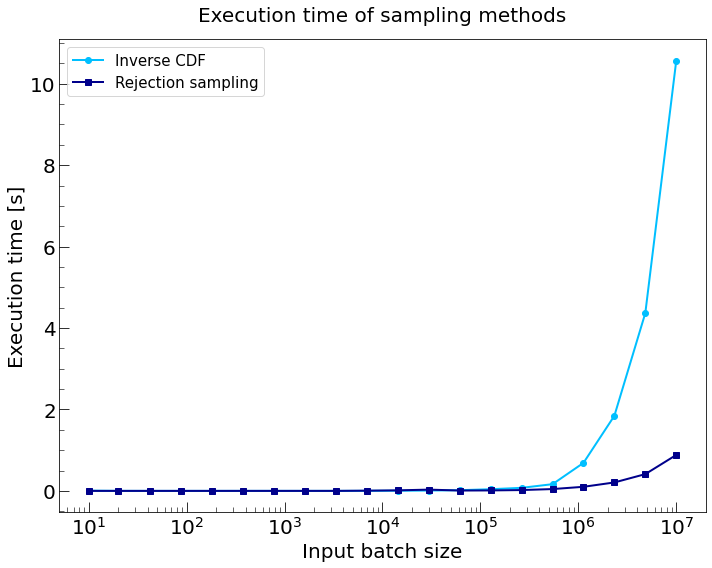

In [ ]:
# Plot the results 
fig, ax = plt.subplots(1, figsize = (10,8))

ax.plot(N_val, times_CDF,marker = 'o',linewidth=2, label='Inverse CDF', color = 'deepskyblue')
ax.plot(N_val, times_HM,marker = 's', linewidth=2, label='Rejection sampling', color = 'darkblue')

ax.set_title('Execution time of sampling methods' ,fontsize = 20, pad = 18)
ax.set_ylabel('Execution time [s]',fontsize = 20)
ax.set_xlabel('Input batch size',fontsize = 20)                   
ax.tick_params(axis = 'both', which = 'major', direction = 'in', length = 10, labelsize = 20)
ax.tick_params(axis = 'both', which = 'minor', direction = 'in', length = 5)
ax.minorticks_on()
ax.set_xscale('log')
ax.legend(loc='best', fontsize=15, ncol = 1)

fig.tight_layout()
#fig.savefig('figures/ex_time.pdf')
plt.show()

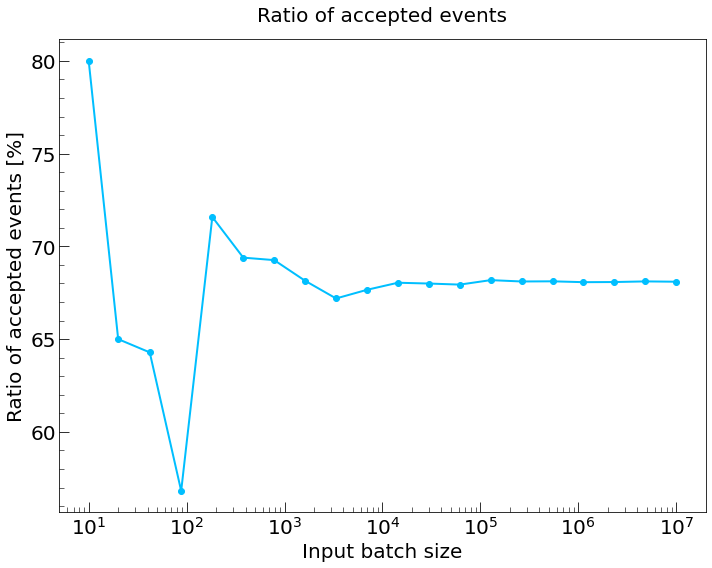

In [ ]:
# Evaluate the fraction of accepted events with rejection sampling method 
N_val = np.logspace(1,7,20, dtype=int)

ratio = []

for i in range(0,len(N_val)):
    theta_samples = hit_miss(ang,(0,np.pi),N_val[i])
    ratio.append(100* len(theta_samples)/N_val[i]) 

# Plot the results 
fig, ax = plt.subplots(1, figsize = (10,8))

ax.plot(N_val,ratio,marker = 'o',linewidth=2, color = 'deepskyblue')

ax.set_title('Ratio of accepted events' ,fontsize = 20, pad = 18)
ax.set_ylabel('Ratio of accepted events [%]',fontsize = 20)
ax.set_xlabel('Input batch size',fontsize = 20)                   
ax.tick_params(axis = 'both', which = 'major', direction = 'in', length = 10, labelsize = 20)
ax.tick_params(axis = 'both', which = 'minor', direction = 'in', length = 5)
ax.minorticks_on()
ax.set_xscale('log')

fig.tight_layout()
#fig.savefig('figures/accepted_events.pdf')
plt.show()

It's evident the rejection sampling is more efficient in terms of execution time. Nevertheless, only a fraction 
of the input events are accepted. This fraction slightly varies in function of the input batch size, but it generally 
is of the order of 65-70%.

***
- Assume a $3$ cm thick Beryllium block is used as a target, and the rate of positrons on the target is $10^6$ Hz. Compute a rescaling factor (weight) you need to apply to each one of the $N$ simulated events such that they represent the statistics that would be gathered in a week of countinuous operations.
***

# 3. Beryllium target <a class="anchor" id="Section.3"></a>
<div style="text-align: right"><a href="#Section.index">Return to index</a></div>

The number of $\mu^+ \mu^-$ pairs produced per positron bunch on target is given by [LEMMA](https://arxiv.org/pdf/1509.04454.pdf):
$$n_\mu =  n_+ \rho^- l_t \sigma $$
where $n_+$ is the number of positrons in the bunch, $\rho^-$ is the electron density in the medium, $l_t$ is the thickness of the target, and $\sigma$ is the total cross section for the $e^+ e^- \to \mu^+ \mu^-$ process.
We can then express it as a function of the impinging positrons rate $f_+$, which reads:
$$f_\mu =  f_+ \rho^- l_t \sigma $$

 $\rho^-$ can be computed as:
$$ \rho^- = N_A \frac{\rho_{\mathrm{Be}}}{M_t} Z $$
with $\rho_{\mathrm{Be}}$ being the target's density, $M_t$ its molar mass, and $Z$ its atomic number. 

So, if we generate $N$ events, the correct statistics for an experiment carried out for a time interval $\Delta T$ can be computed by rescaling histograms by a factor $W = f_\mu \Delta T / N$, with $\Delta T$ in seconds.
Moreover the number of positrons will be :

$$ n_+ =  f_+ \cdot \Delta T $$


Muon pairs produced per second: 1.2581353820329717
Muon pairs produced in a week:  760920.2790535412


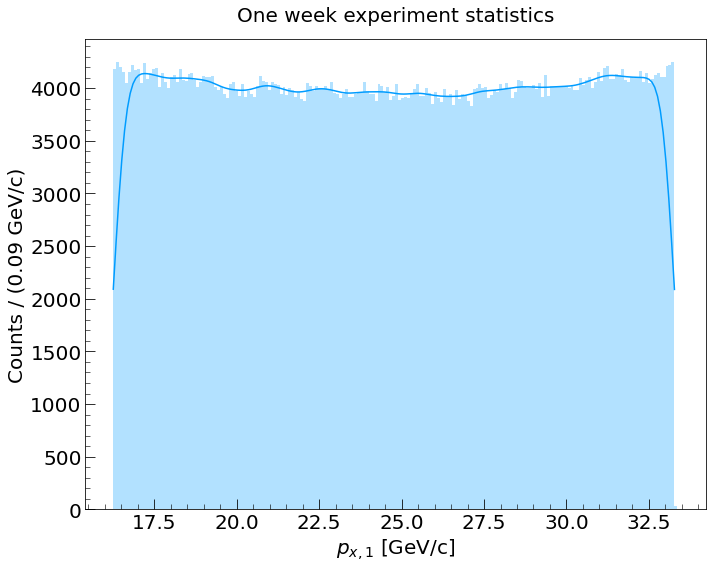

In [ ]:
s = 225**2 
N = 10**6
cross_sec = sigma(s) * conv_fact * 1e-24 # Total cross section [cm^2]

freq    = 1e6            # Positrons rate on target [Hz]
rhoBe = 1.848            # Beryllium density     [g/cm^3]
MBe   = 9.012182         # Beryllium molar mass  [g/mol]
ZBe   = 4                # Beryllium atomic number
lt    = 3                # Target thickness      [cm]
N_a    = 6.02214076e23   # Avogadro's number     [mol^-1]


T     = 3600 * 24 * 7   # seconds in a week

rho_electrons = N_a * rhoBe * ZBe / MBe         # Be Electron density [n.e-/cm^3]
fmu    = freq * rho_electrons * lt * cross_sec  # Rate of produced muon pairs [Hz]
N_week = fmu * T                                # Number of muons produced in a week (rescaling factor)


print('Muon pairs produced per second:', fmu)
print('Muon pairs produced in a week: ', N_week)


weights = np.full(int((N)), N_week/N)            # array of rescaling factors
df_monochromatic['weights'] = weights  


fig, ax = plt.subplots(1, figsize = (10,8))

sns.histplot(x=df_monochromatic['$px_{\mu_1}$']/1000,
             ax=ax,
             stat='count',
             weights= df_monochromatic['weights'], 
             bins = int(np.sqrt(N)), 
             kde=True,
             lw=2,
             edgecolor   = 'None',
             color       = '#009CFF',
             alpha = 0.3,
             binwidth = 0.09
              )


ax.set_title('One week experiment statistics',fontsize = 20, pad = 18)
ax.set_xlabel(r'$p_{x,1}$ [GeV/c]',fontsize = 20)

# plot settings   
ax.set_ylabel('Counts / (0.09 GeV/c)',fontsize = 20)                   
ax.tick_params(axis = 'both', which = 'major', direction = 'in', length = 10, labelsize = 20)
ax.tick_params(axis = 'both', which = 'minor', direction = 'in', length = 5)
ax.minorticks_on()


fig.tight_layout()
#fig.savefig('figures/oneweek_histo.pdf')
plt.show()


***
- Repeat what has been done so far simulating the actual transverse shape and energy spread of the beam: for the former assume a flat distribution in a circle of radius $r=1$ cm and for the latter a gaussian distribution centered at the nominal beam energy and a width of $0.5$ GeV.
***

# 4. Monte Carlo simulation with non monocromatic beam <a class="anchor" id="Section.4"></a>
<div style="text-align: right"><a href="#Section.index">Return to index</a></div> 

Now we deal with a non pointlike beam, indeed it has transverse dimensions (along y and z coordinates).

Moreover another important change has to be considered: the beam is not monochromatic anymore but the energy of the positrons follows a gaussian distribution with a width of $500 MeV$.

First of all, we want to plot the gaussian distribution of energy to have an idea of the distance between the nominal energy and the threshold energy.

To visualize the geometry of the beam, we consider the number of muons arriving every second: $10^6 \mu/s$. These particles will be distributed according to a uniform distribution in circle of radius $1cm$.
We can generate random numbers between [0-1] for the $y$ and $z$ coordinate and use the Acceptance-Rejection method to have a distribution of positrons hitting on the target every second.

We neglect shadow effect, this means that positrons "behind" other positrons are not affected by this configuration. This is a good approximation for relativistic particles we are dealing with.

In [ ]:
#Number of muons per seconds (should be 10**6 but requires too much time in the end I will modify it)
N = 10**4
s = 225**2
#y and z position coordinates generated uniformly in the following array  [[Y-vector],[Z-vector]]
muons = [[],[]]


while (len(muons[0])<N):
    #linear transformation to include all the circle and not only the first quarter:
    #random number between -1 and 1
    y = np.random.random()*2-1
    z = np.random.random()*2-1


    if (y**2+z**2<1):
        muons[0]=np.append(muons[0],y)
        muons[1]=np.append(muons[1],z)

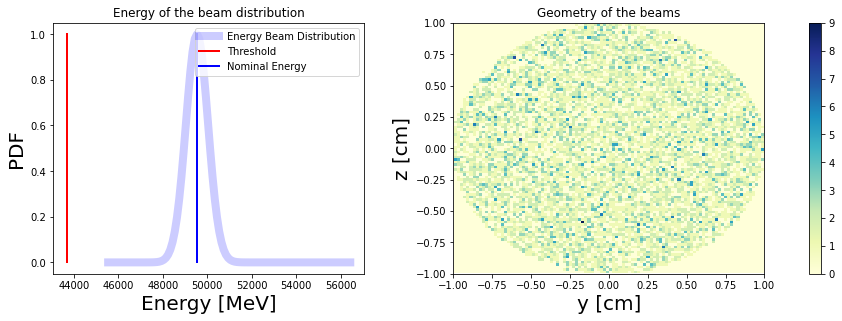

The distance between the nominal energy and the threshold energy is 11.7 sigmas 


In [ ]:
#Energy in the CM is now distributed with a gaussian peaked at E_cm
#Energy of the positron in the LAB (NOMINAL ENERGY)
E_p = s/(2*me)- me
#width of the gaussian energy
width = 500
#the energy threshold in the cm is s=4*mu**2 but s=2me**2+2*E_pos*me
threshold = 4*mu**2/(2*me)-me

def EnergyBeam(x):
    return (np.exp(-((x-E_p)**2/(2*width**2))))

#plot the gaussian distribution graphically
xaxis_energy = np.arange(E_p-8*width,E_p+14*width,100)
yaxis = EnergyBeam(xaxis_energy)



#graphic
fig, ax = plt.subplots(1,2,figsize=(15,6))
fig.tight_layout(pad=8.0)
ax[0].plot(xaxis_energy, yaxis, color='b', lw=8,label="Energy Beam Distribution",alpha=0.2)
ax[0].set_title('Energy of the beam distribution')
ax[0].set_xlabel('Energy [MeV]',fontsize=20)
ax[0].set_ylabel('PDF', fontsize=20)
line_x = [threshold, threshold]
line_x2 = [E_p, E_p]
line_y = [0, 1]
ax[0].plot(line_x, line_y, c='r', label='Threshold', lw=2)
ax[0].plot(line_x2, line_y, c='b', label='Nominal Energy',lw=2)
ax[0].legend(loc='upper right')



h=ax[1].hist2d(muons[0], muons[1],bins=100, cmap='YlGnBu')
ax[1].set_title('Geometry of the beams')
ax[1].set_xlabel('y [cm]',fontsize=20)
ax[1].set_ylabel('z [cm]',fontsize=20)
ax[1].set_xlim(-1,1)
ax[1].set_ylim(-1,1)
fig.colorbar(h[3], ax=ax)
plt.show()

dist=np.abs(E_p-threshold)/width
print("The distance between the nominal energy and the threshold energy is %.1f sigmas " %dist )

Since the energy of positrons is not constant anymore, the Mandelstam variable $\sqrt{s}$ will assume different values for every process $e^{+}+e^{-} \rightarrow \mu^{+}+\mu^{-}$. This also implies that we have to perform different Lorentz boost for each reaction considered.


To do so, we proceeded with this general scheme:

* Generate energy of positron in the lab with the gaussian distribution plotted above $E_{pos}^{lab}$
* From the energy get $\gamma$ factor of positron in the lab $\gamma= \frac{E_{pos}^{lab}}{m_e}$
* Get $\beta$ from $\gamma$
* Get spatial momentum modulus of the positrons in the lab $p_{pos}^{lab}=m_e\cdot\beta_{pos}^{lab}\cdot\gamma_{pos}^{lab}$
* Find invariant mass for that energy knowing both the energy and the momentum of the positron and the electron: $M^2=s=\left(p_{e+}^{\mu}+p^{e-}_{\mu}\right)^2$
* Get $\gamma_{boost}$ of the center of mass frame with respect to the lab from the total energy in the two frames: $\gamma_{boost}=\frac{E_{pos}^{lab}+m_e}{M} $:
* get $\beta_{boost}$ from $\gamma_{boost}$

With $\beta_{boost}$ and $\gamma_{boost}$ we can perform whatever lorentz transformation between the two frames, aiming to get the momentum distribution in the lab frame.

Finally, we will generate $\phi$ angle uniformly and $\theta$ angle according to the distribution $g(\theta^*)$. We will boost this angle knowing $\beta_{boost}$ and $\gamma_{boost}$ for that energy.

In order to get a set with sufficient statistics, we will repeat this scheme for $10^5$ times

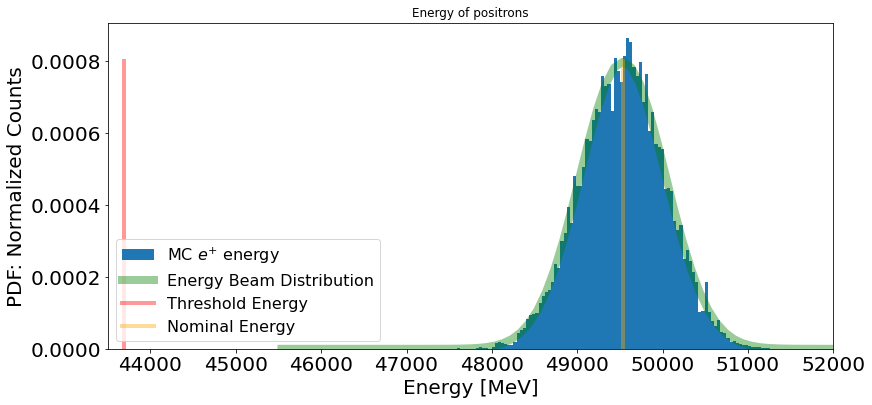

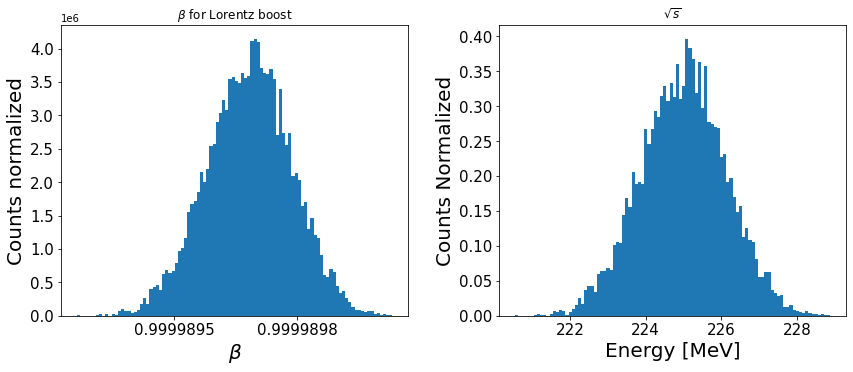

In [ ]:
#Here there are the numpy arrays with the useful kinematic variables

#Set of energy of the positron distributed gaussian
E_pos_lab_gaus = np.random.normal(E_p, width, N)

#Gamma factor for each positron in the lab
gamma_pos_lab = E_pos_lab_gaus/me            #v

#beta factor for each positron (velocity of the positron in the lab)
beta_pos_lab = np.sqrt(1-1/gamma_pos_lab**2)  #v

#momentum of each positron in the lab
p_pos_lab = me*beta_pos_lab*gamma_pos_lab    #v

#invariant mass aka sqrt(s)
M = np.array([])
M = np.sqrt(2*me**2+2*E_pos_lab_gaus*me)    #v

#gamma and beta of the cm wrt lab (the ones to be used for the boost of positrons)
gamma_boost = (E_pos_lab_gaus+me)/M          #correction! me    v
beta_boost = np.sqrt(1-1/gamma_boost**2)      #v

#velocity in the CoM Frame
#beta_cm = s/(s+2*mu**2)

#for the boost of angles we need beta in CoM for the muons!   v
beta_cm_mu=np.sqrt((M**2-4*mu**2)/(M**2))


fig, axes = plt.subplots(1,1,figsize=(13,6))

axes.hist(E_pos_lab_gaus,bins=100,density=True, label="MC $e^{+}$ energy")
axes.set_title("Energy of positrons")
axes.plot(xaxis_energy, yaxis/np.sqrt(2*np.pi*width**2), color='g', lw=8,label="Energy Beam Distribution",alpha=0.4)

#Plotting threshold
line_y = [0, 0.0008]
line_x2 = [E_p, E_p]
axes.plot(line_x, line_y, c='r',lw=4,alpha=0.4, label='Threshold Energy ')

#Plotting nominal energy
axes.plot(line_x2, line_y, c='orange', lw=4, alpha=0.4,label='Nominal Energy')

#graphic stuffs
axes.set_xlim(43500,52000)
axes.set_xlabel("Energy [MeV]",fontsize=20)
axes.set_ylabel('PDF: Normalized Counts',fontsize=20)
axes.tick_params(axis='both', which='major', labelsize=20)
axes.legend(loc='best',prop={'size': 16})
plt.show()




# plot of beta and sqrt(s)
fig, axes2 = plt.subplots(1,2,figsize=(13,6))
fig.tight_layout(pad=6.0)
axes2[0].hist(beta_boost,bins=100,density=True)
axes2[0].set_title("$ \\beta$ for Lorentz boost")
axes2[0].ticklabel_format(useOffset=False, style='sci')
axes2[0].xaxis.set_major_locator(plt.MaxNLocator(3))
axes2[0].set_xlabel("$\\beta$", fontsize=20)
axes2[0].set_ylabel("Counts normalized",fontsize=20)
axes2[0].tick_params(axis='both', which='major', labelsize=15)

axes2[1].hist(M,bins=100,density=True)
axes2[1].set_title("$\\sqrt{s}$")
axes2[1].set_xlabel('Energy [MeV]', fontsize=20)
axes2[1].set_ylabel('Counts Normalized',fontsize=20)
axes2[1].tick_params(axis='both', which='major', labelsize=15)


#axes[2].ticklabel_format(useOffset=False, style='sci')
#axes[2].xaxis.set_major_locator(plt.MaxNLocator(3))


plt.show()

Now that all the kinematic variables are calculated for each of the $10^6$ event that occur per second (assuming energy above the threshold as we will see later), we can generate the angular variables from the knwon distributions. Before doing it let's check if every positron have enough energy to initiate the process:


In [ ]:
not_enough=0
for i in E_pos_lab_gaus:
    if i<threshold:
        not_enough=not_enough+1
if not_enough!=0:
    print("%.3f muons do not have enough energy!")
else:
    print("All the muons have enough energy to initiate the process")

All the muons have enough energy to initiate the process


##  Muons production 
Since all the positrons have enough energy to initiate the process we consider the production of $10^6$ pairs muon-antimuon per seconds emitted after the collision.

Firstly we generate the angular variables in center of mass frame starting from the known distribution. Since no sharp peaks are present in the distribution of $\theta$ we use the acceptance-rejection method.

It is easy to check analytically that the maximum of the function occurs at $ \theta=\frac{\pi}{2}$

Using the Acceptance-Rejection Method one has to know the maximum of the distribution $g(\theta^*)$ that slightly depends on the energy of the process as we can check below

Mean upper limit 0.4898


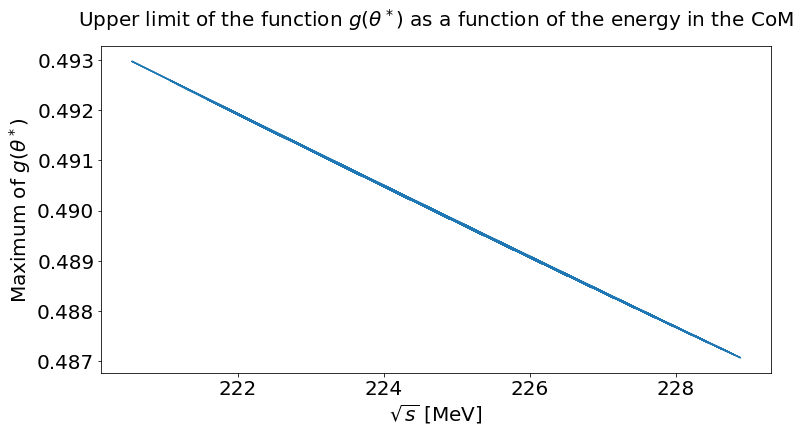

The differences are of the order of 0.654 %


In [ ]:
#array for theta angles in the CoM
angle_cm = np.array([])
#notice that the limit depends on the energy (even if very slight dependence)
#array of upper limit of the maximum of the distribution (the max occurs always at pi/2)
s_arr =np.power(M,2)
upper = ang(s_arr, np.pi/2)
print("Mean upper limit %.4f"%np.mean(upper))

#Graphical plot
fig, axes4 = plt.subplots(1,1,figsize=(12,6))
h=axes4.plot(M,upper)
axes4.set_xlabel("$\sqrt{s}$ [MeV]",fontsize=20)
axes4.set_ylabel('Maximum of $g(\\theta^*)$',fontsize=20)
axes4.tick_params(axis='both', which='major', labelsize=20)
axes4.set_title("Upper limit of the function $g(\\theta^*)$ as a function of the energy in the CoM", fontsize = 20, pad = 20)

plt.show()

val=(upper.max()-upper.mean())/upper.mean()*100
print("The differences are of the order of %.3f" % val,"%") 

In [ ]:
#GENERATION OF THETA ANGLES

while len(angle_cm)<N:
    u = np.random.uniform(0, np.pi)
    r = np.random.uniform(0, upper[len(angle_cm)])      #take the upper limit for the specific event depending on the energy of positron
    if (r<ang(M**2,u)[len(angle_cm)]):
        angle_cm=np.append(angle_cm,u)

#generation of phi angle
phi = np.random.uniform(0, 2*np.pi, N)

In [ ]:
#Consider the variation of 3 sigma in the energy in the lab, what is the variation of energy in cm?
s1=2*me**2+2*E_p*me
s2=2*me**2+2*((E_p+3*width)*me)
s3=2*me**2+2*((E_p-3*width)*me)
print("Energy in the CoM from E_lab \t\t%.1f MeV"% np.sqrt(s1))
print("Energy in the CoM from E_lab+3*sigma  \t%.1f MeV" %np.sqrt(s2))
print("Energy in the CoM from E_lab-3*sigma  \t%.1f MeV"%np.sqrt(s3))

Energy in the CoM from E_lab 		225.0 MeV
Energy in the CoM from E_lab+3*sigma  	228.4 MeV
Energy in the CoM from E_lab-3*sigma  	221.6 MeV


We want to check how much sensible is the dependence on the energy of the angle distribution

In [ ]:
line_theta = [0, np.pi]
line_y = [np.mean(upper),np.mean(upper)]


fig, axs = plt.subplots(1,1,figsize=(15,10))

xaxis_theta=np.linspace(0,np.pi,1000)
#MAIN PLOT

axs.plot(xaxis_theta,ang(s2,xaxis_theta),marker='.',color='orange',linestyle='None',label='Distribution for Nominal Energy + $3\sigma$',alpha=0.8)
axs.plot(xaxis_theta,ang(s3,xaxis_theta),color='green',marker='.',linestyle='None',label='Distribution for Nominal Energy - $3\sigma$',alpha=0.8) 
axs.plot(xaxis_theta,ang(s,xaxis_theta),marker='.',linestyle='None',label='Distribution for Nominal Energy',alpha=0.8)
axs.set_title('Angular distribution')
axs.set_xlabel('CoM angle $\\theta^*[rad]$')
axs.plot(line_theta, line_y, c='r',lw=4,alpha=0.4, label='Upper limit for Nominal Energy')

axs.legend(loc='best',fontsize=15,markerscale=2.5)

#ZOOM AT LOW ANGLES

sub_axes = plt.axes([0.2, 0.35, .2, .4]) 
sub_axes.plot(xaxis_theta,ang(s,xaxis_theta),marker='.',label='Distribution for Nominal Energy') 
sub_axes.plot(xaxis_theta,ang(s2,xaxis_theta),marker='.',label='Distribution for Nominal Energy+3\sigma') 
sub_axes.plot(line_theta, line_y, c='r',lw=4,alpha=0.4, label='Upper limit for Nominal Energy')
sub_axes.plot(xaxis_theta,ang(s3,xaxis_theta),marker='.',color='green',label='Distribution for Nominal Energy-3\sigma',alpha=0.4) 
#sub_axes.set_title("zoom")
sub_axes.set_xlim(0.4,0.5)
sub_axes.set_ylim(0.2,0.25)

#ZOOM AT MIDDLE ANGLES

sub_axes2 = plt.axes([0.75, 0.6, .2, .2]) 
sub_axes2.plot(xaxis_theta,ang(s,xaxis_theta),marker='.',linestyle='None',label='Distribution for Nominal Energy',alpha=0.4) 
sub_axes2.plot(xaxis_theta,ang(s2,xaxis_theta),marker='.',linestyle='None',label='Distribution for Nominal Energy+3\sigma',alpha=0.4) 
sub_axes2.plot(line_theta, line_y, c='r',lw=4,alpha=0.4, label='Upper limit for Nominal Energy')
sub_axes2.plot(xaxis_theta,ang(s3,xaxis_theta),color='green',marker='.',linestyle='None',label='Distribution for Nominal Energy-3\sigma',alpha=0.4) 
#sub_axes2.set_title("zoom")
sub_axes2.set_xlim(1.3,1.7)
sub_axes2.set_ylim(0.47,0.5)


#sub_axes.legend(fontsize=15)

plt.show()

NameError: name 'np' is not defined

As con could expect from the theory, the production of muons is favoured by high energy positrons in the direction (parallel or antiparallel) of the beam, whereas the production along orthogonal direction is favoured by positrons at lower energies. However, this dependence, consequence of the term $\cos(\theta)^{2}$ in the $g(\theta^*)$ distribution is negligible for our purposes but still for sake of generality we took into account it.

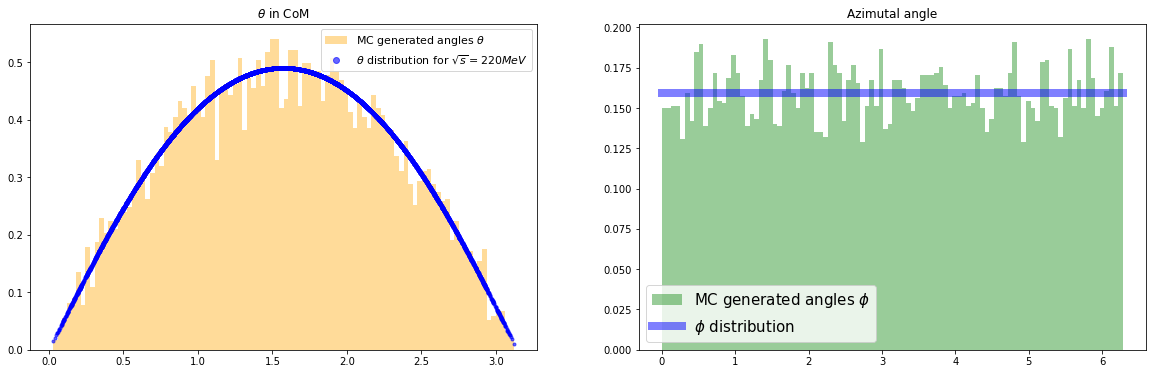

In [ ]:

fig, ax = plt.subplots(1,2,figsize=(20,6))
ax[0].hist(angle_cm,bins=100,density=True, color='orange', alpha=0.4, label='MC generated angles $\\theta$')
ax[0].set_title("$\\theta$ in CoM")
ax[0].plot(angle_cm, ang(s, angle_cm), color='b',linestyle='None', marker='.',label="$\\theta$ distribution for $\\sqrt{s}=220MeV$",alpha=0.6)
ax[0].legend(loc='upper right', fontsize=11,markerscale=2.)

ax[1].hist(phi,bins=100,density=True,color='green',label='MC generated angles $\\phi$',alpha=0.4)
ax[1].set_title("Azimutal angle")
line_x = [0, 2*np.pi]
line_y = [1/(2*np.pi), 1/(2*np.pi)]
ax[1].plot(line_x, line_y, color='b', lw=8,label='$\\phi$ distribution',alpha=0.5)
ax[1].legend(fontsize=15,loc='lower left')

plt.show()


Notice that the distribution is clearly symmetric under $\theta \rightarrow \pi-\theta$ since for each muon emitted at $\theta$ we have a corresponding antimuon emitted at $\pi-\theta$ (or viceversa). For this reason when we will compute the tangent we have to consider also the corresponding opposite value due to the fact that sine is an even function under this transformation but the cosine is an odd one.

Now as done before, we will compute the tangent of these angles and convert it to the lab frame. Since every muon is emitted with different velocities we will employ different Lorentz boost for each particle according to its velocity.

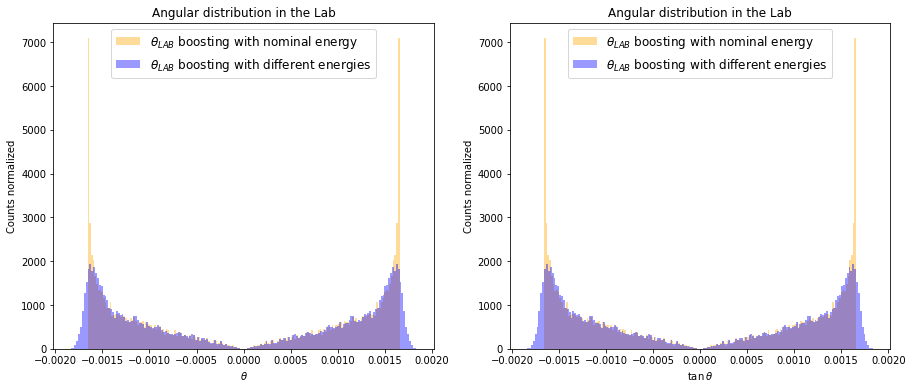

In [ ]:
binnumber=90

fig, ax = plt.subplots(1,2,figsize=(15,6))

#USING only one lorentz transformation:
tantheta=np.sin(angle_cm)/(np.mean(gamma_boost)*(np.cos(angle_cm)+np.mean(beta_boost)/np.mean(beta_cm_mu)))
theta_lab=np.arctan(tantheta)

ax[0].hist(theta_lab,bins=binnumber,color='orange',alpha=0.4,density=True,label='$\\theta_{LAB}$ boosting with nominal energy')
ax[0].hist(-theta_lab,bins=binnumber,color='orange',alpha=0.4,density=True)
ax[0].set_title("Angular distribution in the Lab with one boost")
ax[0].set_xlabel("$\\theta$")
ax[0].set_ylabel("Counts normalized")
#ax.set_xlim(0,0.05)

ax[1].hist(tantheta,bins=binnumber, color='orange',alpha=0.4,density=True,label='$\\theta_{LAB}$ boosting with nominal energy')
ax[1].hist(-tantheta,bins=binnumber, color='orange',alpha=0.4,density=True)
ax[1].set_title("Angular distribution in the Lab with one boost")
ax[1].set_xlabel("$ \\tan{\\theta}$")
ax[1].set_ylabel("Counts normalized")
#ax[1].set_xlim(0,0.001)
#ax[1].set_ylim(0,2000)

tantheta=np.sin(angle_cm)/(gamma_boost*(np.cos(angle_cm)+beta_boost/beta_cm_mu))
theta_lab=np.arctan(tantheta)
ax[0].hist(theta_lab,bins=binnumber,color='b',alpha=0.4,density=True,label='$\\theta_{LAB}$ boosting with different energies')
ax[0].hist(-theta_lab,bins=binnumber,color='b',alpha=0.4,density=True)
ax[0].set_title("Angular distribution in the Lab")
#ax.set_xlim(0,0.05)


ax[1].hist(tantheta,bins=binnumber, color='b',alpha=0.4,density=True,label='$\\theta_{LAB}$ boosting with different energies')
ax[1].hist(-tantheta,bins=binnumber, color='b',alpha=0.4,density=True)
ax[1].set_title("Angular distribution in the Lab")
ax[1].set_xlabel("$ \\tan{\\theta}$")
#ax[1].set_xlim(0,0.001)
#ax[1].set_ylim(0,2000)



ax[0].legend(fontsize=12)
ax[1].legend(fontsize=12)
plt.show()

Using a different Lorentz boost for each muon according to its velocity leads to a more spread distribution.
Notice that since the angles are very little the tangent and the angle itself in radiants are almost the same.


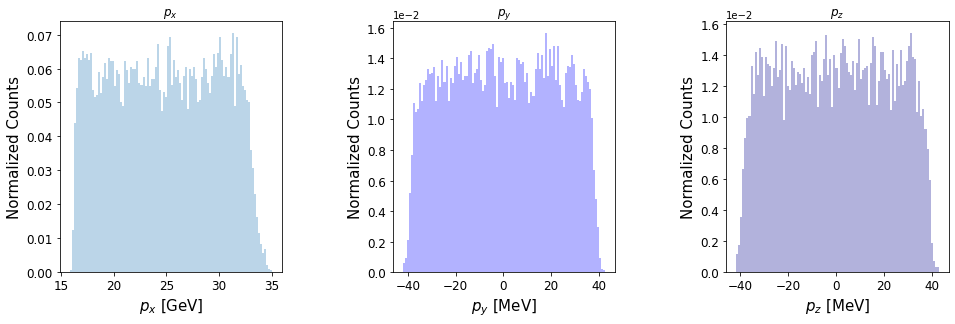

In [ ]:
def gamma_from_E(E, m):
    return (E/m);
def beta_from_E(E, m):
    return (np.sqrt((E**2-m**2)/E**2))
def p_from_E(E,m):
    return np.sqrt(E**2-m**2)
def E_lab_from_cm(beta_boost,theta_cm,gamma_boost=1/np.sqrt(1-beta_boost**2)):
    return (gamma_boost*(E_cm+beta_boost*p_cm*np.cos(theta_cm)))

#ENERGY and MOMENTUM of the muons in the LAB
E_mu_lab=(gamma_boost)*(M/2+(beta_boost)*p_from_E(M/2,mu)*np.cos(angle_cm))
p_mu_lab=p_from_E(E_mu_lab,mu)

bins=100
fig, ax4 = plt.subplots(1,3,figsize=(15,6))

fig.tight_layout(pad=8.0)

#Px
ax4[0].hist(p_mu_lab*np.cos(theta_lab)*10**(-3),bins=bins,alpha=0.3,density=True)
ax4[0].ticklabel_format(axis="x", style="plain", scilimits=(0,0))
ax4[0].set_title('$p_x$')
ax4[0].set_xlabel('$p_x$ [GeV]',fontsize=15)
ax4[0].set_ylabel('Normalized Counts',fontsize=15)
ax4[0].tick_params(axis='both', which='major', labelsize=12)

#Py
ax4[1].hist(p_mu_lab*np.sin(theta_lab)*np.sin(phi),bins=bins,color='blue',alpha=0.3,density=True)
ax4[1].set_title('$p_y$')
ax4[1].set_xlabel('$p_y$ [MeV]',fontsize=15)
ax4[1].set_ylabel('Normalized Counts',fontsize=15)
ax4[1].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
ax4[1].tick_params(axis='both', which='major', labelsize=12)

#Pz same as Py
ax4[2].hist(p_mu_lab*np.sin(theta_lab)*np.cos(phi),bins=bins,color='darkblue',alpha=0.3,density=True)
ax4[2].set_title('$p_z$')
ax4[2].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
ax4[2].set_xlabel('$p_z$ [MeV]',fontsize=15)
ax4[2].set_ylabel('Normalized Counts',fontsize=15)
ax4[2].tick_params(axis='both', which='major', labelsize=12)

plt.show()

Notice that for each positron a pair of muon and antimuon will be produced hence due to momentum conservation the momenta along y and z of the pairs will be opposite whereas the momenta along x will be such that momentum conservation is satisfied:

In [ ]:
#dataframe
p_mu=np.array([])
#p_mu = np.concatenate(p_mu_lab*np.cos(theta_lab),p_mu_lab*np.sin(theta_lab)*np.sin(phi))
#p_mu[1] = p_mu_lab*np.sin(theta_lab)*np.sin(phi)
#p_mu[2] = p_mu_lab*np.sin(theta_lab)*np.cos(phi)
print("Denoting with px, py, pz the momenta of the muons and p2x, p2y p2z momenta of the antimuon")
p_mu=np.concatenate((p_mu_lab*np.cos(theta_lab),p_mu_lab*np.sin(theta_lab)*np.sin(phi)))
p_mu=np.concatenate((p_mu,p_mu_lab*np.sin(theta_lab)*np.cos(phi)))

#separating the array in a N*3
p_mu=p_mu.reshape(3,N)
p_mu=p_mu.T
df = pd.DataFrame(data=p_mu,columns=["px", "py",'pz'])
df['p2x']=p_pos_lab-df.px      #momentum conservation
df['p2y']=-df.py
df['p2z']=-df.pz
df['p_tot_x']=df.px+df.p2x
df.to_csv('Events_gaussian_beam.csv')
df

Denoting with px, py, pz the momenta of the muons and p2x, p2y p2z momenta of the antimuon


,px,py,pz,p2x,p2y,p2z,p_tot_x
0,17568.979982,6.772786,20.621224,32339.083434,-6.772786,-20.621224,49908.063416
1,17750.411367,21.434028,-7.192115,32048.347035,-21.434028,7.192115,49798.758402
2,23924.349720,-29.953222,-24.509689,25694.612406,29.953222,24.509689,49618.962126
3,21361.295155,0.294575,-33.891147,27629.722338,-0.294575,33.891147,48991.017493
4,23503.102714,14.765173,35.200743,26020.954254,-14.765173,-35.200743,49524.056968
...,...,...,...,...,...,...,...
9995,23731.225526,-0.153264,37.350494,25484.545225,0.153264,-37.350494,49215.770752
9996,30536.326258,29.500880,8.891281,19370.565192,-29.500880,-8.891281,49906.891450
9997,22535.309531,20.623767,-32.988217,27591.770590,-20.623767,32.988217,50127.080121
9998,28620.053720,-33.376555,-1.937711,20714.574608,33.376555,1.937711,49334.628328


***
-  Given that the electrons traversing the target lose energy ($E(x)=E_0 \exp{-x/X_0}$, with $x$ the longitudinal coordinate of the target, 
the one parallel to the beam direction and $X_0$ is the Beryllium radiation length), compute the
nominal beam energy $E_0$ such that muon pairs can be generated along the whole length of the target. 
***

# 5. Loss of energy  <a class="anchor" id="Section.5"></a>
<div style="text-align: right"><a href="#Section.index">Return to index</a></div> 

The threshold energy for muon production in the laboratory frame should be slightly higher than the sum of the two 
muons masses:

$$ \sqrt{s}_{\text{th}} \sim 2m_{\mu} \implies s_{\text{th}} \sim 4m_{\mu}^2 $$

Assuming the target's electrons at rest, we can express $s$ as follows:

$$     s = (p_{e^+}+p_{e^-})^2 = \vec p_{e_+}^2+m_{e_-}^2+m_{e_-}^2+2E_{e_+}m_{e_-}-\vec p_{e_+}^2     $$

By using the two conditions we obtain:
$$2E_{e_+}m_{e_-}+2m_{e_-}^2>4m_{\mu}^2\Rightarrow 2E_{e_+}m_{e_-}>4m_{\mu}^2-2m_{e_-}^2$$
Hence, the threshold production condition reads:

$$  E_{e^+,th} > \frac{4m_{\mu}^2 - 2m_{e^-}^2   }{2m_{e^-}} \sim 43.7~\text{GeV} $$

So, with the purpose of having a threshold energy along the whole target we need to impose the same condition at the end
of the latter, i.e. at $x_{max}=l=3$ cm where $l$ is the lenght of the target. 

$$ E_{e^+,th}(x) = E_{e^+,0} \cdot \text{e}^{-l/X_0}  \implies E_{e^+,0} > \frac{4m_{\mu}^2 - 2m_{e^-}^2   }{2m_{e^-}} \cdot \text{e}^{l/X_0} \sim 47.6~\text{GeV} $$

Threshold energy: 47571.03 MeV


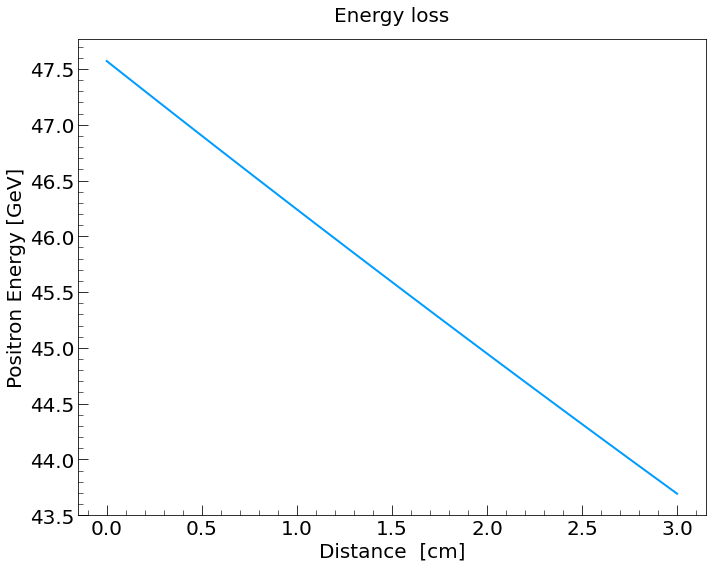

In [22]:
rad_length = 35.28  # Radiation length of Beryllium [cm]
l = 3               # Target thickness [cm]

E_0th = ( (4*mu**2-2*me**2)/(2*me) )*np.exp(l/rad_length)

print ('Threshold energy: {:.2f} MeV'.format(E_0th)) 

### Plot of energy loss in Beryllium ###

x = np.linspace(0,3,100) # distances from 0 to 3 cm 
e = E_0th * np.exp(-x/rad_length) * 1e-03

fig, ax = plt.subplots(1, figsize = (10,8))

ax.plot(x,e, lw=2, ls='-', color = '#009CFF')

ax.set_title('Energy loss' ,fontsize = 20, pad = 18)
ax.set_xlabel('Distance  [cm]',fontsize = 20)
ax.set_ylabel('Positron Energy [GeV]',fontsize = 20)                   
ax.tick_params(axis = 'both', which = 'major', direction = 'in', length = 10, labelsize = 20)
ax.tick_params(axis = 'both', which = 'minor', direction = 'in', length = 5)
ax.minorticks_on()

fig.tight_layout()
#fig.savefig('figures/energy_loss.pdf')
plt.show()


The energy loss in Beryllium is not significant as the exponential trend is not visible from the plot. Indeed along the 
3 cm target, the positrons lose in average roughly 0.4 GeV. This aspect can be further analyzed by comparing the energy loss
trend in different materials. Therefore, we consider a some elements, e.g. Litium, Carbon, Iron. 

Put reference to https://pdg.lbl.gov/2021/AtomicNuclearProperties/

In [19]:
# Build a dataframe with some material and corresponding properties

Material = [   'Li',  'Be',    'B',    'C',     'Al',   'Fe',   'Cu',   'W',    'Pb']        # Material 
Z        = [   3,     4,       5,      6,    13,     26,      29,     74,     82]            # Atomic number  
M        = [ 6.941, 9.01218, 10.811, 12.0107,  26.9815, 55.6934,63.546, 183.84, 207.2]       # Molar mass [g/mol]
density  = [ 0.5340, 1.8477 , 2.370,   2.0,   2.699 ,   7.874 ,  8.96,   19.3 ,  11.35]      # Density [g/cm^3]
X0       = [ 155.0, 35.28,    22.23,   21.35, 8.897 ,  1.757,   1.436,   0.3504,  0.5612]    # Radiation lenght [cm]

# Create a dictionary with materials and properties 
dic_properties = {'Material': Material, 'Z': Z, 'M': M,'Density': density, 'X0': X0}
properties = pd.DataFrame(data=dic_properties)
properties


,Material,Z,M,Density,X0
0,Li,3,6.94100,0.5340,155.0000
1,Be,4,9.01218,1.8477,35.2800
2,B,5,10.81100,2.3700,22.2300
3,C,6,12.01070,2.0000,21.3500
4,Al,13,26.98150,2.6990,8.8970
5,Fe,26,55.69340,7.8740,1.7570
6,Cu,29,63.54600,8.9600,1.4360
7,W,74,183.84000,19.3000,0.3504
8,Pb,82,207.20000,11.3500,0.5612


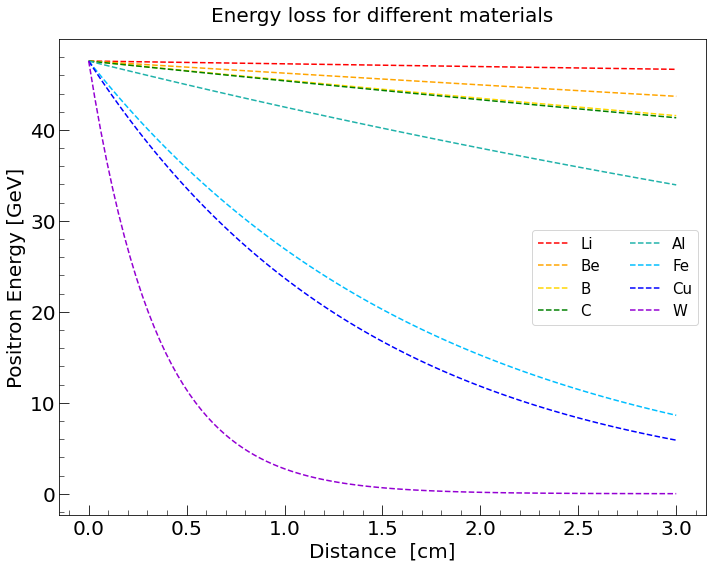

In [20]:
### Plot of energy loss or different materials ###
colors = ['red', 'orange', 'gold', 'green', 'lightseagreen', 'deepskyblue', 'blue', 'darkviolet']

x = np.linspace(0,3,100) # distances from 0 to 3 cm 

fig, ax = plt.subplots(1, figsize = (10,8))

for i in range(0,8):
    ax.plot(x, E_0th * np.exp(-x/properties.at[i,'X0'])* 1e-03,label = properties.at[i,'Material'], color = colors[i],ls='dashed')
    
ax.set_title('Energy loss for different materials' ,fontsize = 20, pad = 18)
ax.set_xlabel('Distance  [cm]',fontsize = 20)
ax.set_ylabel('Positron Energy [GeV]',fontsize = 20)                   
ax.tick_params(axis = 'both', which = 'major', direction = 'in', length = 10, labelsize = 20)
ax.tick_params(axis = 'both', which = 'minor', direction = 'in', length = 5)
ax.minorticks_on()

ax.legend(loc='best', fontsize=15, ncol = 2)

fig.tight_layout()
#fig.savefig('figures/energy_loss_materials.pdf')

plt.show()

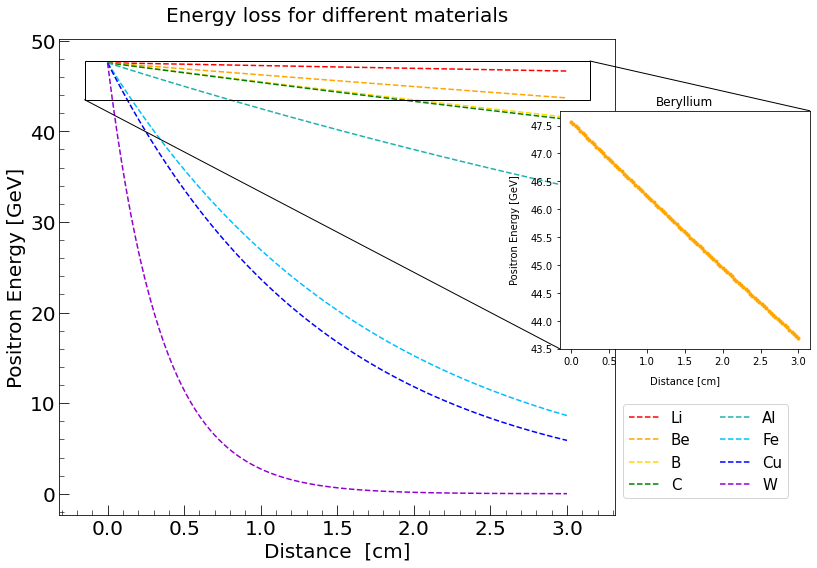

In [76]:
### Plot of energy loss or different materials ###
colors = ['red', 'orange', 'gold', 'green', 'lightseagreen', 'deepskyblue', 'blue', 'darkviolet']

x = np.linspace(0,3,100) # distances from 0 to 3 cm 

fig, ax = plt.subplots(1, figsize = (12,8))

for i in range(0,8):
    ax.plot(x, E_0th * np.exp(-x/properties.at[i,'X0'])* 1e-03,label = properties.at[i,'Material'], color = colors[i],ls='dashed')

ax.set_title('Energy loss for different materials' ,fontsize = 20, pad = 18)
ax.set_xlabel('Distance  [cm]',fontsize = 20)
ax.set_ylabel('Positron Energy [GeV]',fontsize = 20)                   
ax.tick_params(axis = 'both', which = 'major', direction = 'in', length = 10, labelsize = 20)
ax.tick_params(axis = 'both', which = 'minor', direction = 'in', length = 5)
ax.minorticks_on()

ax.legend(loc='best', fontsize=15, ncol = 2,bbox_to_anchor=(1, 0.25))

e = E_0th * np.exp(-x/rad_length) * 1e-03

ax_ins = ax.inset_axes([0.9, 0.35, 0.45, 0.5], transform=ax.transAxes)
ax_ins.set_title('Beryllium',fontsize=12)
ax_ins.set_ylabel('Positron Energy [GeV]', fontsize = 10, loc = 'center',labelpad=10)
ax_ins.set_xlabel('Distance [cm]', fontsize = 10, loc = 'center',labelpad=10)
ax_ins.plot(x,e,'orange',marker='.')
ax_ins.set_yticks(np.arange(43.5,48,0.5))
ax.indicate_inset_zoom(ax_ins,edgecolor='black',alpha = 1)



fig.tight_layout()
#fig.savefig('figures/energy_loss_materials_insert.pdf')

plt.show()




## Non-monochromatic beam
Similarly we carried out a parallel analysis with the non-monochromatic beam in the following way: we imposed that the positrons with energy greater than the nominal one minus 3 sigmas of the gaussian dispersion produce a couple $\mu\overline{\mu}$. Repeating the same argument we find that :

$$E_{th}^{lab}=\frac{4m_{\mu}^2 - 2m_{e^-}^2   }{2m_{e^-}} \cdot \text{e}^{l/X_0} \sim 47.6~\text{GeV} = E_{nominal}-3\sigma=E_{peak}-3\cdot500MeV$$
This means that the peak of the gaussian distribution must be at approximately $$E_{peak}=E_{th}^{lab}+3\cdot500MeV=49.1GeV$$


Let's see how the gaussian distribution evolves while crossing the target:


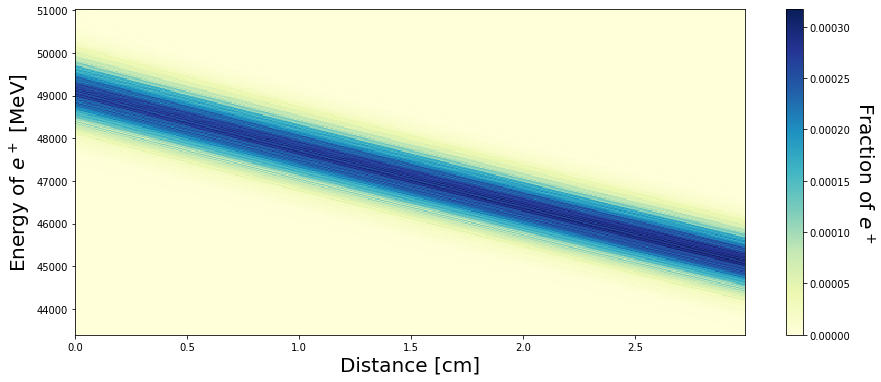

In [ ]:
#position 0
grid=300
points = np.linspace(0,l,grid)
x_ax_grid = np.tile(points[:-1], (N, 1))
E_peak=49100
E_gaus = np.array([])
E_gaus = np.random.normal(E_peak,width,N)

E=np.array([])

for i in range (grid-1) :
    E = np.append(E,E_gaus)
    E_gaus = E_gaus*np.exp(-lt/grid/properties.X0[1])

E=E.reshape(grid-1,N)

fig, ax = plt.subplots(1,1,figsize=(15,6))
histo=ax.hist2d(x_ax_grid.T.flatten(), np.concatenate(E),bins=grid-1, cmap='YlGnBu',density=True)
ax.set_xlabel("Distance [cm]",fontsize=20)
ax.set_ylabel("Energy of $e^+$ [MeV]",fontsize=20)
fig.colorbar(histo[3], ax=ax).set_label('Fraction of $e^+$', rotation=270,fontsize=20,labelpad=24)

plt.show()

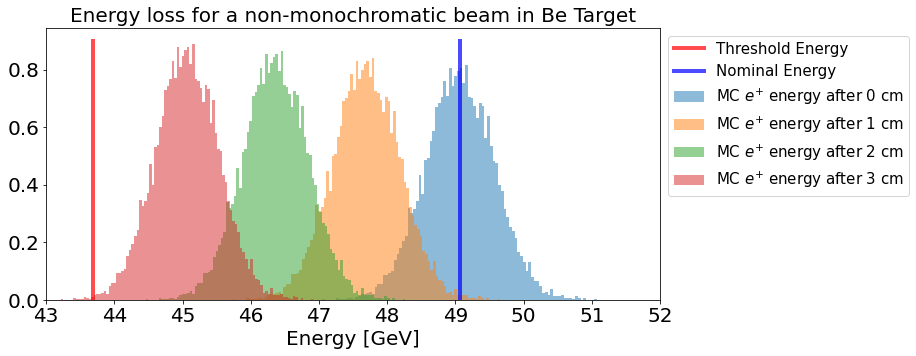

In [ ]:
#Here there are the numpy arrays with the useful kinematic variables
N=10**4

threshold_loss=(4*mu**2-2*me**2)/(2*me)
E_p_loss=threshold_loss*np.exp(3/rad_length) + 3*width

#Set of energy of the positron distributed gaussian
E_pos_lab_gaus_loss = np.random.normal(E_p_loss, width, N)

M = np.array([])
M = np.sqrt(2*me**2+2*E_pos_lab_gaus_loss*me)    #v


fig, axes2 = plt.subplots(1,1,figsize=(11,5))
    #Plotting threshold
line_x = [threshold_loss/1000,threshold_loss/1000]
line_y = [0, 0.9]
axes2.plot(line_x, line_y, c='r',lw=4,alpha=0.7, label='Threshold Energy')

    #Plotting nominal energy
line_x2 = [E_p_loss/1000, E_p_loss/1000]
axes2.plot(line_x2, line_y, c='blue', lw=4, alpha=0.7,label='Nominal Energy')
for j in range(4):
    axes2.hist(E_pos_lab_gaus_loss/1000,bins=100,density=True, label="MC $e^{+}$ energy after %.1d cm"%(j),alpha=0.5)
    axes2.set_title("Energy loss for a non-monochromatic beam in Be Target" ,fontsize=20)

    axes2.set_xlabel("Energy [GeV]",fontsize=20)
    axes2.tick_params(axis='both', which='major', labelsize=20)
    axes2.legend(loc='best',fontsize=15,bbox_to_anchor=(1, 1))
    E_pos_lab_gaus_loss = E_pos_lab_gaus_loss*np.exp(-1/rad_length)
axes2.set_xlim(43,52)
plt.show()


In principle we expected a reduction in the width of the gaussian but this effect is negligible even if it can bee seen looking at the height of the normalized gaussian: the last one is the highest due to a reduction in the dispersion.

For sake of curiosity let's see what happens for heavier materials using the same beam:

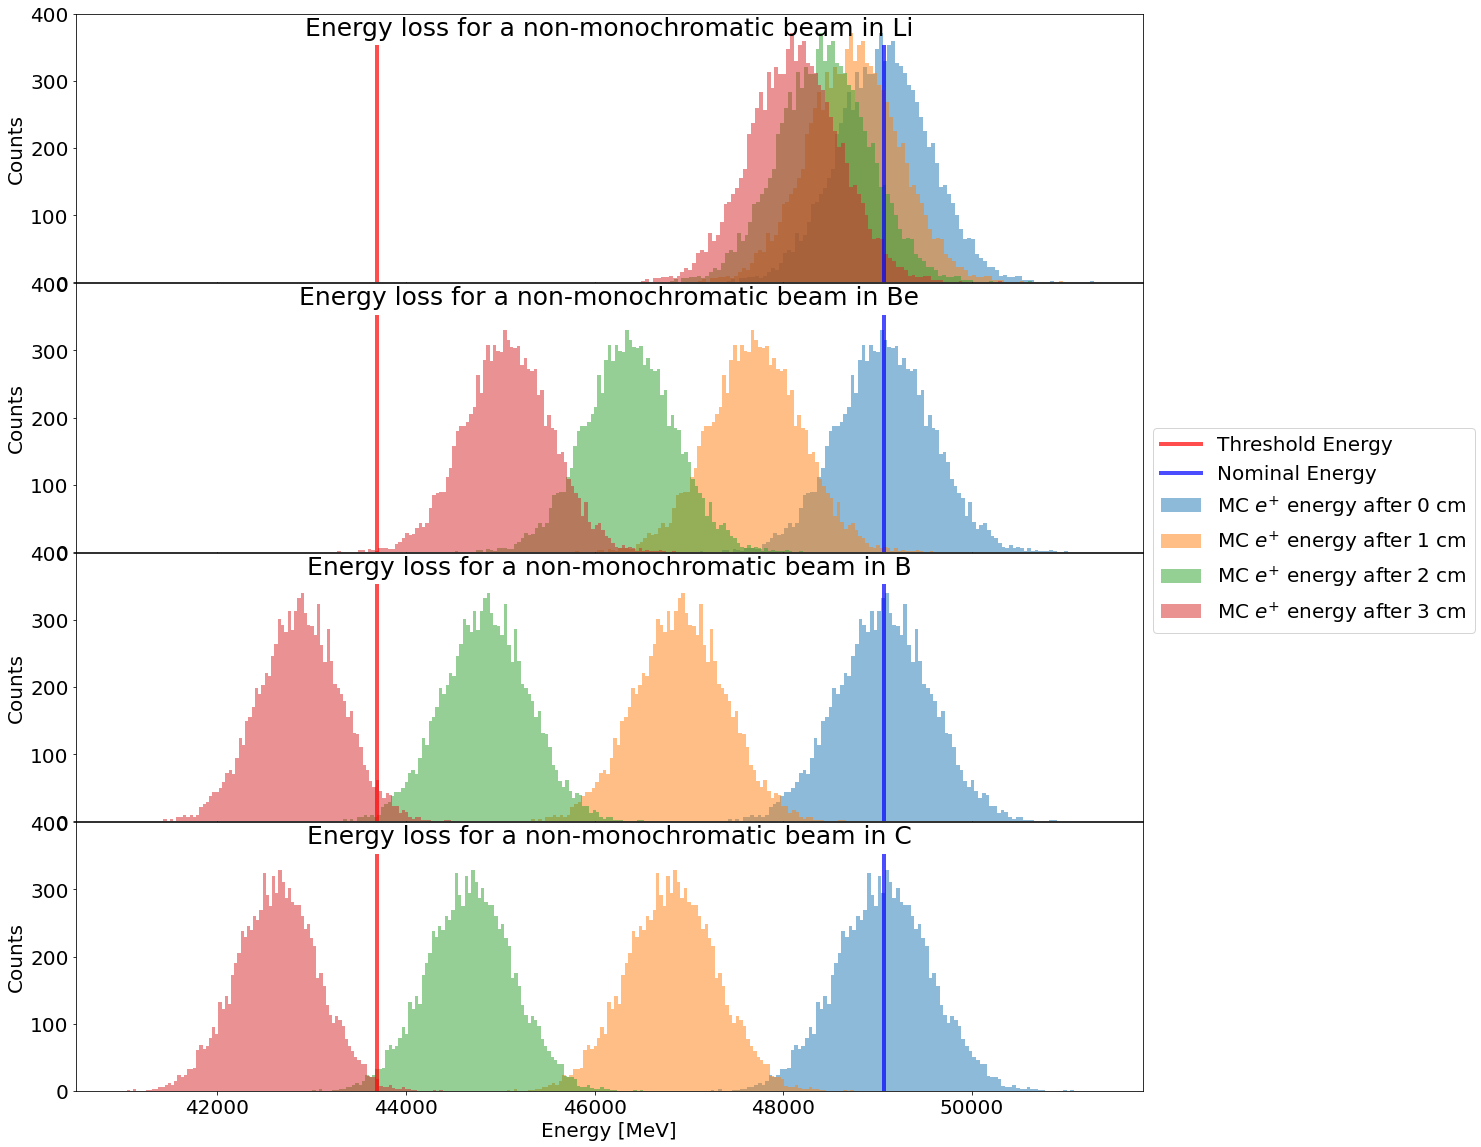

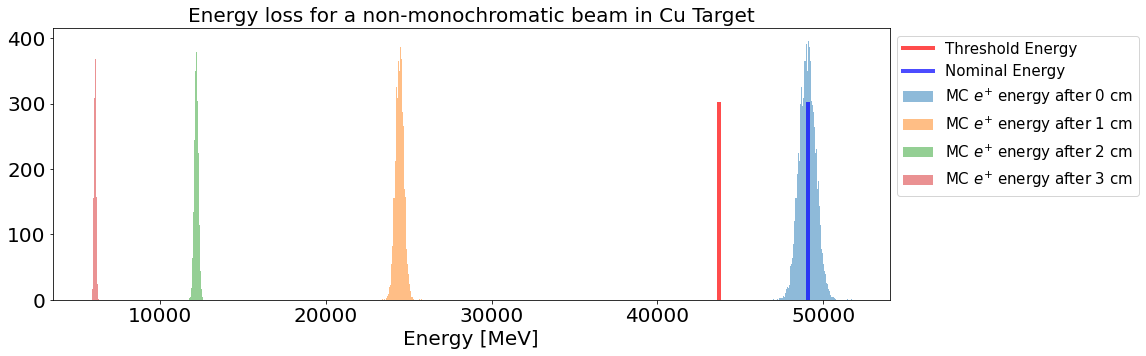

In [ ]:
fig, axes2 = plt.subplots(4,1,figsize=(15,15),sharex=True,)
fig.tight_layout(pad=-0.9)
line_y = [0, 350]
materials=["Li","Be","B","C"]

#B Target
for i in range(4):
    E_pos_lab_gaus_loss = np.random.normal(E_p_loss, width, N)

#Plotting threshold
    axes2[i].plot(line_x, line_y, c='r',lw=4,alpha=0.7, label='Threshold Energy')
#Plotting nominal energy
    axes2[i].plot(line_x2, line_y, c='blue', lw=4, alpha=0.7,label='Nominal Energy')
    for j in range(4):
        axes2[i].hist(E_pos_lab_gaus_loss,bins=100, label="MC $e^{+}$ energy after %.1d cm"%(j),alpha=0.5)
        axes2[i].set_title("Energy loss for a non-monochromatic beam in "+materials[i],fontsize=25, y=0.9)
        axes2[i].set_xlabel("Energy [MeV]",fontsize=20)
        axes2[i].tick_params(axis='both', which='major', labelsize=20)
        axes2[i].set_ylim(0,400)
        axes2[i].set_ylabel("Counts",fontsize=20)
        E_pos_lab_gaus_loss = E_pos_lab_gaus_loss*np.exp(-1/properties.X0[i])

axes2[1].legend(loc='best',fontsize=20,bbox_to_anchor=(1, 0.5))
plt.show()

#Cu
line_y = [0, 300]
E_pos_lab_gaus_loss = np.random.normal(E_p_loss, width, N)
fig, axes2 = plt.subplots(1,1,figsize=(15,5))

#Plotting threshold
#line_x = [threshold_loss,threshold_loss]
#line_y = [0, 0.0009]
axes2.plot(line_x, line_y, c='r',lw=4,alpha=0.7, label='Threshold Energy')

#Plotting nominal energy
line_x2 = [E_p_loss, E_p_loss]
axes2.plot(line_x2, line_y, c='blue', lw=4, alpha=0.7,label='Nominal Energy')
for j in range(4):
    axes2.hist(E_pos_lab_gaus_loss,bins=100,label="MC $e^{+}$ energy after %.1d cm"%(j),alpha=0.5)
    axes2.set_title("Energy loss for a non-monochromatic beam in Cu Target" ,fontsize=20)

    axes2.set_xlabel("Energy [MeV]",fontsize=20)
    axes2.tick_params(axis='both', which='major', labelsize=20)
    axes2.legend(loc='best',fontsize=15,bbox_to_anchor=(1, 1))
    E_pos_lab_gaus_loss = E_pos_lab_gaus_loss*np.exp(-1/properties.X0[6])
#axes2.set_xlim(43*10**3,52*10**3)
plt.show()

In heavier elements we also see the effect of reduction of dispersion in the gaussian distribution

***
 - **Optional:** as in the previous point, take into account the loss of energy (and thus $\sqrt{s}$) along the target when generating the events.

***

# Simulation with energy loss
We now take into account the loss of energy along the target when generating the events, both for a monochromatic and non-monochromatic beam. 
## Monochromatic beam
From the previous point we have seen that the minimum positron energy required to have muon pairs production along the whole target, i.e. a non-zero
cross section, is equal to $ E_{0,th} \sim 47.6~\text{GeV} $. This value corresponds to an invariant mass $\sqrt{s} \sim 220.6$ MeV. So, in order
to satisty the aforementioned condition, we choose a CoM energy slightly greater, i.e. $\sqrt{s} = 225$ MeV, which corresponds to a positron 
initial energy E $_0 \sim 49.54~\text{GeV}$. The energy loss leads to a variable pair-production probability depending on the cross section along the target. 
We need to generate the position along the x-axis inside the target and then retrieve the angular distribution of the emitted muons in the CoM frame, 
using the **acceptance-rejection method**. We simply sample uniformly from a rectangular distribution and then retain only the points underlying the desired distribution.
So we'll proceed in the following way:

- we first need to compute the invariant mass depending on the initial energy $\text{E}_0$ and on the position $x$;
- then we compute the cross section, according to the initail energy and point of interaction;
- we divide the target into a range of discrete intervals in order to obtain the number of interactions in function of the travelled distance;
- knowing the total number of produced muon pairs (in one week), we can infer how many interactions occur in each slice of the target lenght  

In [ ]:
def s_att(x,E0):
    '''
        Function that calculates s in function of the initial energy E_0
        and of the position x inside the target. 

        Parameters:
        x: position in the medium [cm]
        E0: initial positrons energy [MeV]

        Returns:
        s [MeV^2]
    '''

    return 2 * me**2 + 2 * E0 *np.exp(-x/rad_length) * me

def sigma_att(x,E0):
    '''
        Function that calculates the cross section in function of
        the initial energy E_0 and of the position x inside the target. 

        Parameters:
        x: position in the medium [cm]
        E0: initial positrons energy [MeV]

        Returns:
        sigma [MeV^-2] 
    '''

    return sigma(s_att(x,E0))

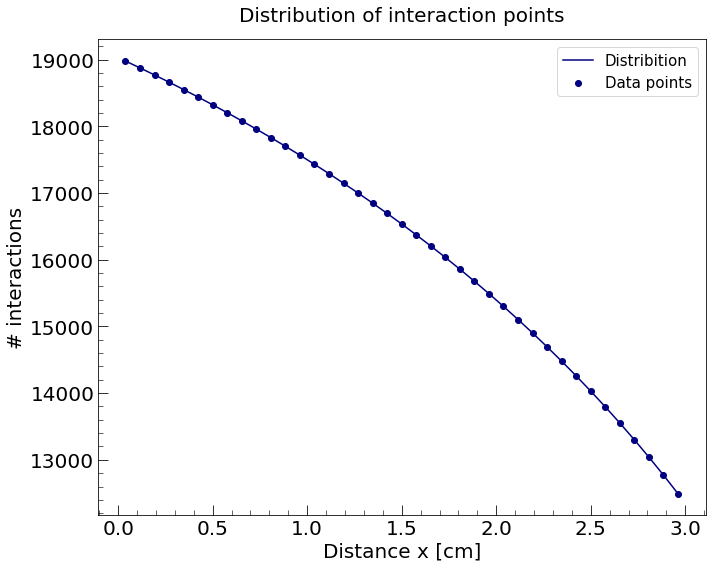

In [ ]:
E_0 = 49.54 * 1000  # positrons initial energy [MeV]
n_grid = 40         # number of grid points 

scale = (l/n_grid) *  389.4 * 1e-24 * rho_electrons  # scaling factor and conversion from MeV^-2 to cm^2 

points = np.linspace(0,l,n_grid)            # array of grid points
points = (points[1:] + points [:-1]) / 2    # we take the middle point of each piece 

T     = 3600 * 24 * 7                       # seconds in a week
n_part_tot = T * 10**6                      # number of positrons considering f = 10^6 Hz

particles = np.zeros(n_grid)                # initialize array to store number of particles in each interval
particles[0] = n_part_tot                   # initial number 

for i in range(n_grid-1):
    prob = 1 - scale * sigma_att(points[i],E_0)  # probability of not interacting -> used to calculate how many particles 
                                                 # can still interact after at a certain distance 
    particles[i+1] = particles[i] * prob  

n_interactions = particles[:-1] - particles[1:] # subtract the number of particles in interval [i+1] from the one in [i]

# normalize to total number of interactions 

fig, ax = plt.subplots(1, figsize = (10,8))

# use intep1d to find the distribution for the interaction points
dist = interp1d(points,n_interactions, fill_value ='extrapolate') 

# if we want to find the normalized distribution we need to divide buìy the sum of the # of interactions  
# n_interactions_nor = n_interactions / n_interactions.sum()
# dist = interp1d(points,n_interactions,fill_value ='extrapolate")
                        
ax.plot(points, dist(points), color = 'navy',label = 'Distribition')
ax.scatter(points, n_interactions, marker = 'o', color = 'navy', label = 'Data points')

ax.set_title('Distribution of interaction points' ,fontsize = 20, pad = 18)
ax.set_xlabel('Distance x [cm]',fontsize = 20)
ax.set_ylabel('# interactions',fontsize = 20)                   
ax.tick_params(axis = 'both', which = 'major', direction = 'in', length = 10, labelsize = 20)
ax.tick_params(axis = 'both', which = 'minor', direction = 'in', length = 5)
ax.minorticks_on()
ax.legend(loc='best', fontsize=15, ncol = 1)


fig.tight_layout()
#fig.savefig('figures/int_points_mono.pdf')
plt.show()

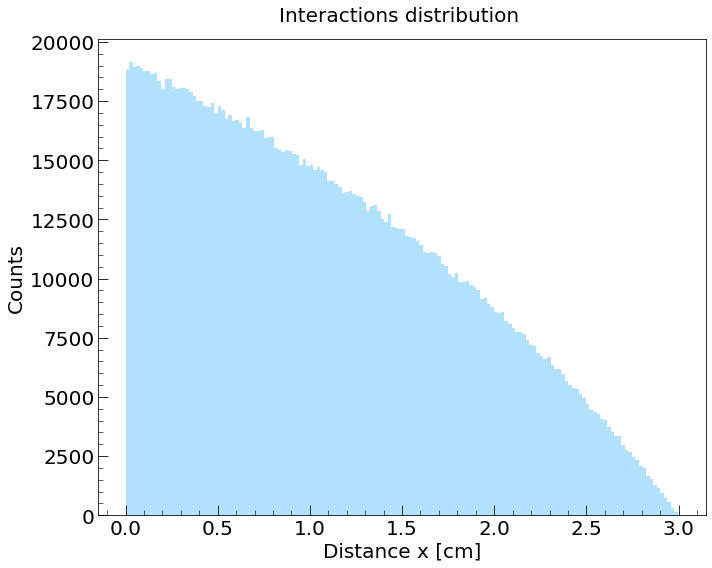

In [ ]:
# accept-reject method according to the distribution above
accepted_events = []
N = 10**6

'''
Same result but way less efficient!!

while len(accepted_events) < N: 
    dist_points = np.random.uniform(0,l)
    check = np.random.uniform(dist(3),dist(0))
    if(check < dist(dist_points)):
        accepted_events.append(dist_points)
'''

dist_points = np.random.uniform(0, l, 3*N) 
check = np.random.uniform(dist(3), dist(0), 3*N)   
accepted_events = dist_points[check < dist(dist_points)]


fig, ax = plt.subplots(1, figsize = (10,8))

sns.histplot(x=accepted_events,
             ax=ax,
             stat='count',
             lw=2,
             edgecolor   = 'None',
             color       = '#009CFF',
             alpha = 0.3
              )

ax.set_title('Interactions distribution ', fontsize = 20, pad = 18)
ax.set_xlabel('Distance x [cm]',fontsize = 20)

# plot settings   
ax.set_ylabel('Counts',fontsize = 20)                   
ax.tick_params(axis = 'both', which = 'major', direction = 'in', length = 10, labelsize = 20)
ax.tick_params(axis = 'both', which = 'minor', direction = 'in', length = 5)
ax.minorticks_on()


fig.tight_layout()
#fig.savefig('figures/int_points_dist.pdf')
plt.show()

In [ ]:
# Apply accept-reject on previously accepted points according to cross section in each interval

# Generate angles in CoM frame 
angles = np.random.uniform(0, np.pi, len(accepted_events))
check_ang = np.random.uniform(0, ang(s_att(accepted_events, E_0),np.pi/2), len(accepted_events)) 

# create Dataframe 
df_energies_mono_att = pd.DataFrame(s_att(accepted_events, E_0), columns = ['Energy']) # s values of accepted events 
df_energies_mono_att['Angles'] = angles                                                
df_energies_mono_att['emission_point'] = accepted_events                               # column with interaction point 
df_energies_mono_att['check']  = check_ang

# accept only the events that satisfy the condition, i.e. follow the wanted distribution                                        
df_energies_mono_att[r'$\theta^*$']  = df_energies_mono_att.Angles[df_energies_mono_att.check < ang(df_energies_mono_att.Energy, df_energies_mono_att.Angles)] 
# drop columns with NaN -> events that do not follow the distribution 
df_energies_mono_att = df_energies_mono_att.dropna()
# keep only N events 
df_energies_mono_att = df_energies_mono_att.iloc[:N]

df_energies_mono_att

,Energy,Angles,emission_point,check,$\theta^*$
2,49472.033858,2.773306,0.816481,0.017361,2.773306
3,49229.393198,1.472522,0.989943,0.449038,1.472522
6,49592.632513,1.574092,0.730582,0.280420,1.574092
7,49289.692556,2.440917,0.946755,0.121996,2.440917
9,48826.610566,1.890514,1.279785,0.210000,1.890514
...,...,...,...,...,...
1545967,49893.343157,0.941428,0.517301,0.295870,0.941428
1545968,50011.521533,1.546756,0.433834,0.321311,1.546756
1545970,49615.176109,1.256784,0.714548,0.279354,1.256784
1545972,47425.349910,1.801996,2.307100,0.075979,1.801996


To simulate the events with different values of s, starting from `generate_beam`, we slightly modify the function
in order to give as input a DataFrame containing different energies.

In [ ]:

def generate_beam_df(df):

    bunch_size = df.shape[0]
    pnorm = norm(df.Energy) # Norm of muon 3-momentum in CM
    
    # Compute inverse CDF of g(theta*) by interpolation 
    theta_star = np.linspace(0, np.pi, N)
    inv_cdf = interp1d(g_cdf(df.Energy, theta_star), theta_star, fill_value='extrapolate')

    # Sample angles
    num_samples = N
    unif_samples = np.random.uniform(size=bunch_size)

    phis = np.random.uniform(0, 2 * np.pi, size=bunch_size)
    thetas = inv_cdf(unif_samples)
    
    
    # Compute cartesian components of 3-vector
    px_cm = pnorm * np.cos(df.Angles)
    py_cm = pnorm * np.sin(df.Angles) * np.cos(phis)
    pz_cm = pnorm * np.sin(df.Angles) * np.sin(phis)


    _,px1 = boost_coordinates(df.Energy, px_cm)  # px for first muon
    _,px2 = boost_coordinates(df.Energy, -px_cm) # px for second muon
    # py and pz are orthogonal to boost axis, and so they remain the same
    
    return np.stack((px1, py_cm, pz_cm, px2, -py_cm, -pz_cm), axis=1)    


# generate events 
events_att = generate_beam_df(df_energies_mono_att)
# save events in txt file and dataframe 
np.savetxt('Momenta_monochromatic_attenuated.txt', events_att) # save to file
df_monochromatic_att = pd.DataFrame(events_att, columns = [ '$px_{\mu_1}$','$py_{\mu_1}$','$pz_{\mu_1}$','$px_{\mu_2}$','$py_{\mu_2}$','$pz_{\mu_2}$'])
df_monochromatic_att.to_csv('Events_attenuated_mono.csv')
df_monochromatic_att


,$px_{\mu_1}$,$py_{\mu_1}$,$pz_{\mu_1}$,$px_{\mu_2}$,$py_{\mu_2}$,$pz_{\mu_2}$
0,17157.109760,-11.859564,3.930057,31249.556844,11.859564,-3.930057
1,24804.986623,-23.964215,-23.629699,23364.262018,23.964215,23.629699
2,24237.103344,25.827484,-23.820023,24287.566100,-25.827484,23.820023
3,18461.581050,-14.209292,-16.726016,29766.669041,14.209292,16.726016
4,21692.970858,30.651032,-0.668681,26082.164809,-30.651032,0.668681
...,...,...,...,...,...,...
999995,29065.242994,-28.970054,-4.074409,19753.664476,28.970054,4.074409
999996,24659.761892,-32.910834,15.977836,24274.780234,32.910834,-15.977836
999997,26644.038386,14.631483,-30.128214,21902.689418,-14.631483,30.128214
999998,21916.964271,25.169311,-4.773037,24487.072046,-25.169311,4.773037


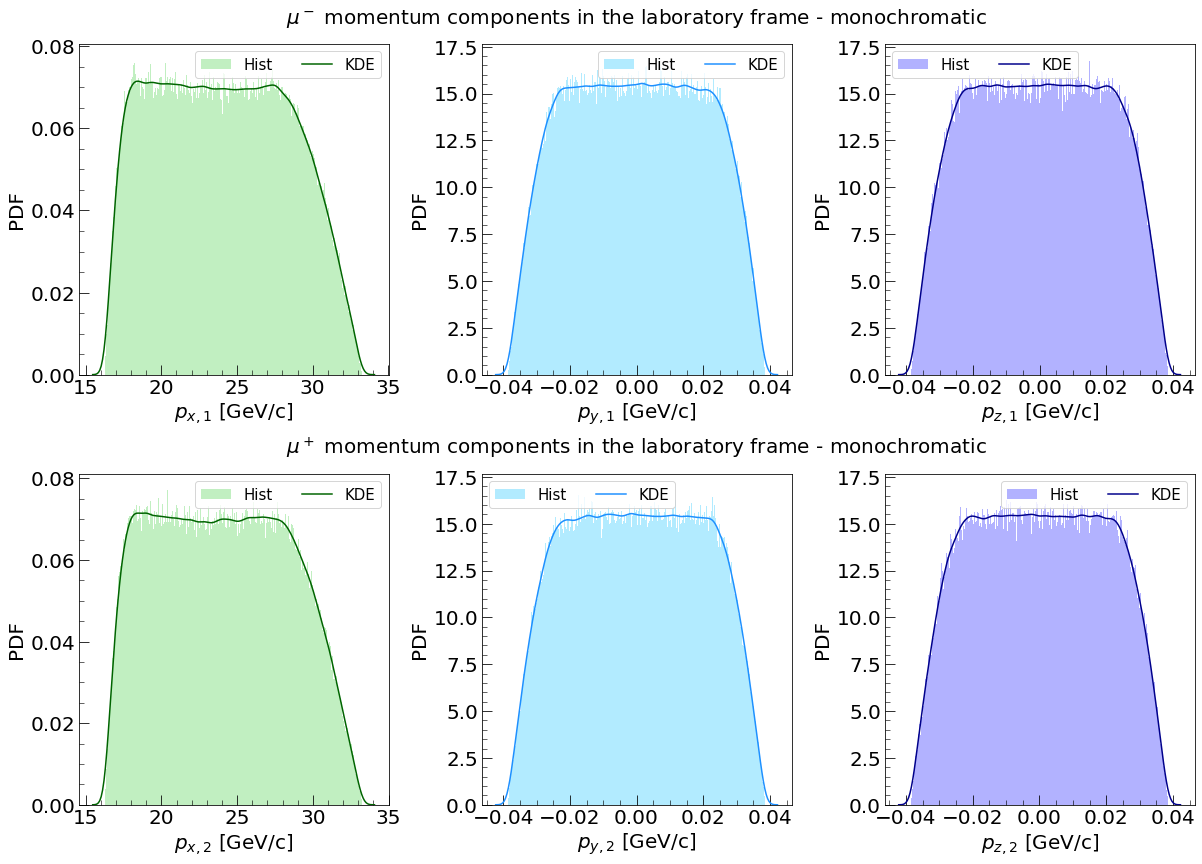

In [ ]:
fig, ax = plt.subplots(2,3, figsize = (20,14))

# plotting momentum components distribution in the LAB frame



### MUON 1 ###
# px
sns.distplot(df_monochromatic_att['$px_{\mu_1}$']/1000,
             ax = ax[0][0],
             bins = int(np.sqrt(N)),
             kde = True,
             kde_kws  = {'color': 'darkgreen',   'label': 'KDE'},
             hist_kws = {'color': 'limegreen', 'alpha': 0.3, 'linewidth': 1, 'histtype':'barstacked', 'label': 'Hist'}
             )

            
# py
sns.distplot(df_monochromatic_att['$py_{\mu_1}$']/1000,
             ax = ax[0][1],
             bins = int(np.sqrt(N)),
             kde = True,
             kde_kws  = {'color': 'dodgerblue',   'label': 'KDE'},
             hist_kws = {'color': 'deepskyblue', 'alpha': 0.3, 'linewidth': 1, 'histtype':'barstacked', 'label': 'Hist'}
             )
            
# pz
sns.distplot(df_monochromatic_att['$pz_{\mu_1}$']/1000,
             ax = ax[0][2],
             bins = int(np.sqrt(N)),
             kde = True,
             kde_kws  = {'color': 'darkblue',   'label': 'KDE'},
             hist_kws = {'color': 'blue', 'alpha': 0.3, 'linewidth': 1, 'histtype':'barstacked', 'label': 'Hist'}
            )


ax[0][0].set_xlabel(r'$p_{x,1}$ [GeV/c]',fontsize = 20)
ax[0][1].set_xlabel(r'$p_{y,1}$ [GeV/c]',fontsize = 20)
ax[0][2].set_xlabel(r'$p_{z,1}$ [GeV/c]',fontsize = 20)

ax[0][1].set_title('$\mu^-$ momentum components in the laboratory frame - monochromatic',fontsize = 20,pad = 20)


### MUON 2 ###
# px
sns.distplot(df_monochromatic_att['$px_{\mu_2}$']/1000,
             ax = ax[1][0],
             bins = int(np.sqrt(N)),
             kde = True,
             kde_kws  = {'color': 'darkgreen',   'label': 'KDE'},
             hist_kws = {'color': 'limegreen', 'alpha': 0.3, 'linewidth': 1, 'histtype':'barstacked', 'label': 'Hist'}
             )
            
# py
sns.distplot(df_monochromatic_att['$py_{\mu_2}$']/1000,
             ax = ax[1][1],
             bins = int(np.sqrt(N)),
             kde = True,
             kde_kws = {'color':'dodgerblue','label':'KDE'},
             hist_kws = {'color': 'deepskyblue', 'alpha': 0.3, 'linewidth': 1, 'histtype':'barstacked', 'label': 'Hist'}
             )
            
# pz
sns.distplot(df_monochromatic_att['$pz_{\mu_2}$']/1000,
             ax = ax[1][2],
             bins = int(np.sqrt(N)),
             kde = True,
             kde_kws  = {'color': 'darkblue', 'label':'KDE'},
             hist_kws = {'color': 'blue', 'alpha': 0.3, 'linewidth': 1, 'histtype':'barstacked', 'label': 'Hist'}
            )


ax[1][0].set_xlabel(r'$p_{x,2}$ [GeV/c]',fontsize = 20)
ax[1][1].set_xlabel(r'$p_{y,2}$ [GeV/c]',fontsize = 20)
ax[1][2].set_xlabel(r'$p_{z,2}$ [GeV/c]',fontsize = 20)

ax[1][1].set_title('$\mu^+$ momentum components in the laboratory frame - monochromatic',fontsize = 20, pad = 20)

for ax in fig.get_axes():
    # plot settings   
    ax.set_ylabel('PDF',fontsize = 20)                   
    ax.tick_params(axis = 'both', which = 'major', direction = 'in', length = 10, labelsize = 20)
    ax.tick_params(axis = 'both', which = 'minor', direction = 'in', length = 5)
    ax.minorticks_on()
    ax.legend(loc='best', fontsize=15, ncol = 2)



plt.subplots_adjust(hspace=.3,wspace=.3)
plt.show()
#fig.savefig('figures/momentum_mono_loss.png')


## Non-monochromatic analysis
We will deal with an Energy matrix with n_grid rows and N columns, where n_grid is the number of slices in which we divide the target along the longitudinal direction and N is the number of positrons, so that the energy of the positron $i$ at the slice number $j$ will be the entry $E[i,j]$

In [ ]:
N=10**5
E_peak=49540             #in order NOT to have all the positrons above the threshold for sake of generality
E_pos_lab_gaus=np.random.normal(E_peak,width,N)
n_grid=40
points = np.linspace(0,l,n_grid)
edges=points
points = (points[1:] + points [:-1]) / 2    # we take the middle point of each piece 
                                            #notice the middle points are n_grid-1

def E_lab_to_s(E):
    '''Takes energy in lab convert it to the mandelstam s'''
    return 2*me**2+2*me*E

#Energy at slice 0 is the initial energy of N positrons
E_gaus = np.array([])
E_gaus = np.random.normal(E_peak,width,N)
E=np.array([])
for i in range (n_grid) :
    E = np.append(E,E_gaus)
    E_gaus = E_gaus*np.exp(-l/n_grid/properties.X0[1]) 

E=E.reshape(n_grid,N)   #E calculated in the edges not in the middle points
print("E is a ", np.shape(E), " matrix\n")   

flag=False #boolean True if there is at least a positron with E<threshold
#check if in the positrons having reched the end of the target there is still energy
for index in range(N):
    if E[n_grid-1][index]<threshold:    #matrix energy in last layer of material, cycle over the N positrons
        flag=True
        break
if flag:  
    print("First index in which a positron doesn't have enough energy \t", index)      
    print("Corresponding Energy of the positron \t\t\t\t", int(E[n_grid-1][index]))
    print("Threshold \t\t\t\t\t\t\t", int(threshold))
    #The cross section is a nan
    print("Cross section for energy below the threshold \t\t\t", sigma(E_lab_to_s(E[n_grid-1][index])),"\n")
    #The physical meaning is that the cross section is zero since there is no way to produce the pair
    #Once a positron reaches the threshold will never interact so the cross section will remain zero

else:
    print("All the positrons have enough energy even at the last point of the target\n")


#A matrix of particles is required:
#we consider initially 
particles = np.zeros(n_grid*N)                # initialize array to store number of particles in each interval
particles=particles.reshape(n_grid,N)
particles[0] = n_part_tot                   # slice 0
#print(particles[0],len(prob))

#At each middle point we want the interactions to occurr
#But each of the n_part_tot particles will have different energies according to the gaussian distribution
#so different probability to interact

for i in range(n_grid-1):
    prob = 1 - scale * np.nan_to_num(sigma(E_lab_to_s(E[i])))   
                                        # probability of not interacting -> used to calculate how many particles 
                                        # can still interact after at a certain distance 
                                        # prob is an array of lenght N with the prob of 
                                        # non interacting for a set of N particles
    particles[i+1] = particles[i] * prob  
    #most of the times we will have energy near the peak of the gaussian
    #so the corresponding cross section is the most probable
    #so this prob of non interacting will have the most frequent value
    #this is done in order to see the occurences of the remaining paarticles

print("edges is an array of the edges with length:\t\t",np.shape(edges)," ")
print("points is an array of middle points with length:\t",np.shape(points)," ")
print("particles is a \t\t",np.shape(particles)," matrix since it is computed in the edges")
n_interactions = particles[:-1] - particles[1:] 
print("n_interactions is a\t",np.shape(n_interactions)," matrix since it is computed in the middle points")

E is a  (40, 100000)  matrix

All the positrons have enough energy even at the last point of the target

edges is an array of the edges with length:		 (40,)  
points is an array of middle points with length:	 (39,)  
particles is a 		 (40, 100000)  matrix since it is computed in the edges
n_interactions is a	 (39, 100000)  matrix since it is computed in the middle points


If there is at least one positron with no energy enough we will need to remove tha NaN values and replace them with 0 values from the cross section array. The physical meaning of this operation is that for energy below the threshold the cross section is zero since there is no way to produce the pair.

Once a positron reaches the threshold, it will never interact so the cross section will remain zero.

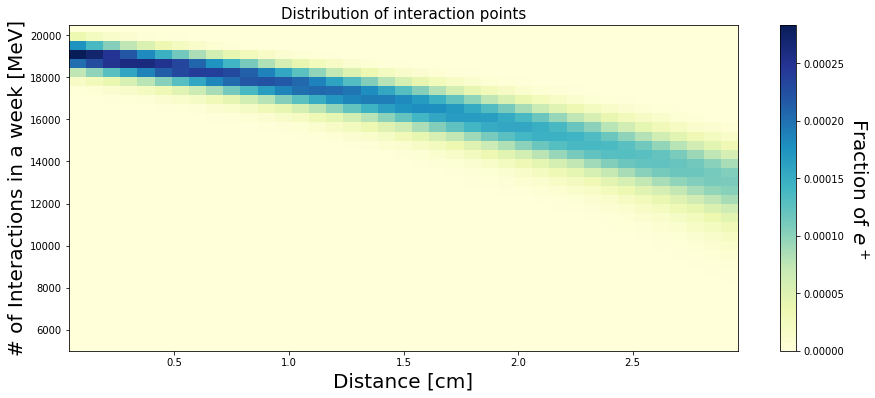

In [ ]:
x_ax_grid = np.tile(points[:], (N, 1))   #we need an array with x axis given by "points" for each positrons

fig, ax = plt.subplots(1,1,figsize=(15,6))
histo=ax.hist2d(x_ax_grid.T.flatten(), np.concatenate(n_interactions),bins=n_grid-1, cmap='YlGnBu',density=True)
ax.set_title("Distribution of interaction points",fontsize=15)
ax.set_xlabel("Distance [cm]",fontsize=20)
ax.set_ylabel("# of Interactions in a week [MeV]",fontsize=20)
fig.colorbar(histo[3], ax=ax).set_label('Fraction of $e^+$', rotation=270,fontsize=20,labelpad=24)
ax.set_ylim(5000,20500)
plt.show()

Meaning of the graph: in the firt slice of material we cannot say,  like in the monochromatic case, that there will be just a certain number of interactions in a week but on **average** there will be a certain number of interactions in a week with a dispersion due to the non monochromatic beam

In this case we have a distribution of energy so in principle there is the possibility that a positron doesn't have enogh energy to initiate the process for all the lenght of the target, but because of the loss of energy the process is possible until a certain distance. We will be dealing with an array of maximum distances not a value anymore. Of course, if the energy is enough the maximum distance to produce the pair $\mu\overline{\mu}$ is the length of the target.


In [ ]:
def max_dist(E0, X0=rad_length):
    return np.log(E0/threshold)*X0

N=10**5
l=3
#arrays of max dist and of interp1d functions
max_dist_array = np.array([])
array_interp = np.array([])

for j in range(N):
    Ej=E_pos_lab_gaus[j]
    if  max_dist(Ej) < l:
        max_dist_array=np.append(max_dist_array,max_dist(Ej))
    else:
        max_dist_array=np.append(max_dist_array,l)
    
    #part_per_slice = np.zeros(n_grid)
    #part_per_slice[0] = n_part_tot
    
    #To have equal number of elements in x and y need a definition of slices for each case
    points = np.linspace(0,max_dist(Ej),n_grid)
    mid_p = points
    mid_p = (mid_p[1:] + mid_p[:-1])/2 #middle points for each slice
    
    array_interp=np.append(array_interp,interp1d(mid_p,n_interactions.T[j], fill_value = "extrapolate"))

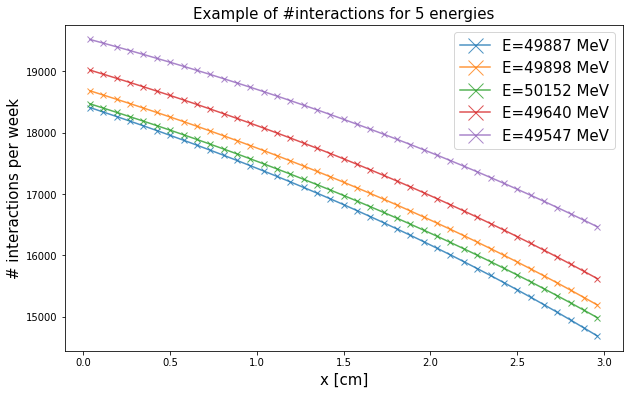

In [ ]:

fig, axs = plt.subplots(1,1,figsize=(10,6))
for i in range(5):
    points = np.linspace(0,max_dist_array[i],n_grid)
    mid_p = points
    mid_p = (mid_p[1:] + mid_p[:-1])/2 #middle points for each slice
    axs.plot(mid_p, array_interp[i](mid_p), marker='x',label='E=%1d MeV'%E_pos_lab_gaus[i],alpha=0.8)

axs.set_title("Example of #interactions for 5 energies", fontsize=15)
axs.set_xlabel("x [cm]",fontsize=15)
axs.set_ylabel("# interactions per week",fontsize=15)

axs.legend(loc='best',fontsize=15,markerscale=2.5)
axs
plt.show()
#print(max_dist_array[1400:1600])
#check in the last layer they are in threshold
#for i in range(5):
#    print(E_pos_lab_gaus[i]*np.exp(-max_dist_array[i]/rad_length))

As in the monochromatic case: consider one of initial N energy of the beam:

* there will be the corresponding maximum distance $x_{max}$ and the interp1d function
* generate random uniform $x$ between $0$ and $x_{max}$
* generate random uniform $y$ between the minimum of the distribution computed in the last point and the maximum computed in the first point
* 

In [ ]:
print(max_dist_array)
print(array_interp[0](max_dist_array))

[3. 3. 3. ... 3. 3. 3.]
[14621.77629046 14621.77629046 14621.77629046 ... 14621.77629046
 14621.77629046 14621.77629046]


In [ ]:
#array of random numbers beteween 0 and the maximum distance
x = np.random.uniform(0, max_dist_array, N)
y = np.random.uniform([func(i) for i,func in zip(max_dist_array,array_interp)],
                          [func(0) for func in array_interp], N)   

#create a dataframe with the energies in the lab
df_final = pd.DataFrame(pd.Series(E_pos_lab_gaus), columns = ['energies_lab'])
df_final["x_gen"] = x
df_final["y_gen"]  = y
df_final["x_emission"]  = df_final.x_gen[df_final.y_gen < [func(i) for i,func in zip(df_final.x_gen,array_interp)]]
df_final['max_dist'] = max_dist_array
df_final

,energies_lab,x_gen,y_gen,x_emission,max_dist
0,49887.616088,2.395117,17742.542329,NaN,3.0
1,49898.421796,2.665466,15632.961180,2.665466,3.0
2,50152.264350,0.231616,17368.269262,0.231616,3.0
3,49640.462526,2.440629,16439.458981,NaN,3.0
4,49547.408272,0.537827,17043.698854,0.537827,3.0
...,...,...,...,...,...
99995,49107.718072,1.562871,15456.437641,1.562871,3.0
99996,49259.973434,2.218374,18738.261158,NaN,3.0
99997,49703.899766,2.746100,14940.027242,NaN,3.0
99998,49532.722049,1.997047,18108.617618,NaN,3.0


In [ ]:
df_final = df_final.dropna()
df_final

,energies_lab,x_gen,y_gen,x_emission,max_dist
1,49898.421796,2.665466,15632.961180,2.665466,3.0
2,50152.264350,0.231616,17368.269262,0.231616,3.0
4,49547.408272,0.537827,17043.698854,0.537827,3.0
9,49582.116033,2.076206,17491.546499,2.076206,3.0
10,49441.799791,0.397168,16919.265767,0.397168,3.0
...,...,...,...,...,...
99987,49468.295244,0.802905,16031.225393,0.802905,3.0
99991,49058.097914,2.119924,17244.079769,2.119924,3.0
99994,49854.979612,0.715236,16370.051767,0.715236,3.0
99995,49107.718072,1.562871,15456.437641,1.562871,3.0


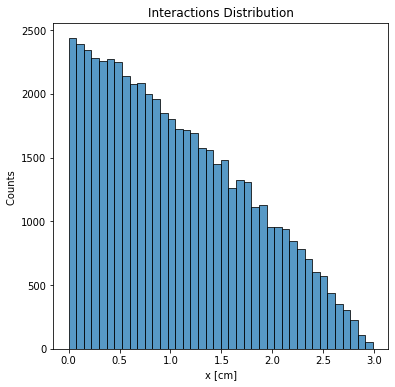

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (6,6))
sns.histplot(
            df_final.x_emission,
            ax = ax,
            bins=40)
ax.set_title("Interactions Distribution")
ax.set_xlabel("x [cm]")
ax.set_ylabel("Counts ")
plt.show()

In [ ]:
pairs = len(df_final.x_emission)
print("The number of pairs produced  in a week is ", pairs,"\n")


df_E = pd.DataFrame(pd.Series(s_att(df_final.x_emission, df_final.energies_lab)), columns = ['s_att'])
df_E["x_emission"] = df_final.x_emission

#first time
angles = np.random.uniform( 0, np.pi, pairs)
ang_check = np.random.uniform(0, ang(s_att(df_final.x_emission, df_final.energies_lab),np.pi/2), pairs)
df_E["x_gen_angle"] = angles
df_E["y_gen_dist"]  = ang_check
df_E["acc_theta_cm"]  = df_E.x_gen_angle[df_E.y_gen_dist < ang(df_E.s_att, df_E.x_gen_angle)]
df_E


The number of pairs produced  in a week is  55320 



,s_att,x_emission,x_gen_angle,y_gen_dist,acc_theta_cm
1,47285.708659,2.665466,1.204913,0.393879,1.204913
2,50920.636974,0.231616,1.697602,0.477492,1.697602
4,49871.781500,0.537827,2.626580,0.468120,NaN
9,47777.326970,2.076206,0.683686,0.284876,0.683686
10,49964.287405,0.397168,2.328623,0.283088,2.328623
...,...,...,...,...,...
99987,49419.440438,0.802905,1.124100,0.199562,1.124100
99991,47213.847429,2.119924,1.092838,0.374554,1.092838
99994,49929.656413,0.715236,2.582372,0.482420,NaN
99995,48013.752013,1.562871,2.846702,0.162719,NaN


In [ ]:
#however some numbers might have been rejected
while len(df_E.dropna()) < pairs:
    angles = np.random.uniform( 0, np.pi, pairs)
    ang_check = np.random.uniform(0, ang(s_att(df_final.x_emission, df_final.energies_lab),np.pi/2), pairs)
    #now regenerate for the nan
    df_E["x_gen_angle"] = angles
    df_E["x_emission"] = df_final.x_emission
    df_E["y_gen_dist"]  = ang_check
    df_E["temp"]  = df_E.x_gen_angle[df_E.y_gen_dist < ang(df_E.s_att, df_E.x_gen_angle)]
    df_E.acc_theta_cm.fillna(df_E.temp, inplace=True)
    df_E.drop('temp', inplace=True, axis=1)

df_E


,s_att,x_emission,x_gen_angle,y_gen_dist,acc_theta_cm
1,47285.708659,2.665466,0.972898,0.416353,1.204913
2,50920.636974,0.231616,2.872440,0.249295,1.697602
4,49871.781500,0.537827,2.036079,0.390638,2.571011
9,47777.326970,2.076206,2.176155,0.083080,0.683686
10,49964.287405,0.397168,0.195531,0.230140,2.328623
...,...,...,...,...,...
99987,49419.440438,0.802905,0.419817,0.473463,1.124100
99991,47213.847429,2.119924,0.457542,0.358093,1.092838
99994,49929.656413,0.715236,0.515865,0.261510,2.070095
99995,48013.752013,1.562871,0.566940,0.374769,0.576365


1        26997.313036
2        23912.820065
4        17992.046484
9        29641.434706
10       19141.066156
             ...     
99987    27992.328173
99991    27098.156983
99994    21003.344899
99995    29935.473074
99999    30185.126232
Length: 55320, dtype: float64


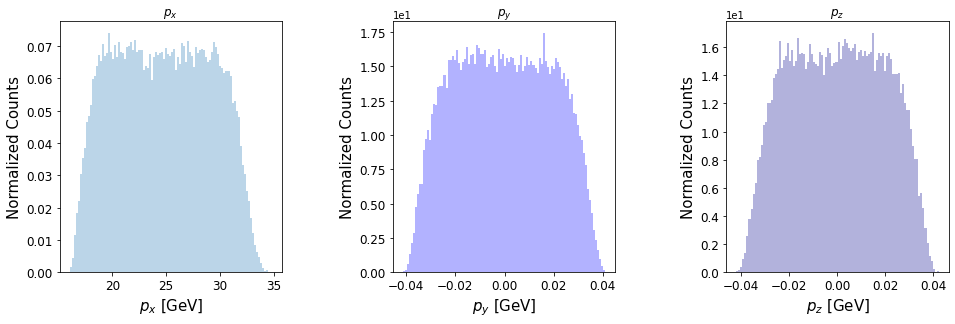

In [ ]:
def gamma_from_E(E, m):
    return (E/m);
def beta_from_E(E, m):
    return (np.sqrt((E**2-m**2)/E**2))
def p_from_E(E,m):
    return np.sqrt(E**2-m**2)
def E_lab_from_cm(beta_boost,theta_cm,gamma_boost=1/np.sqrt(1-beta_boost**2)):
    return (gamma_boost*(E_cm+beta_boost*p_cm*np.cos(theta_cm)))
def beta_from_gamma(gamma ):
    return np.sqrt(1-1/gamma**2)

#gamma boost need to be computed when mumu produced


gamma_boost_el = (df_final.energies_lab*np.exp(-df_final.max_dist/n_grid/properties.X0[1]) +me)/np.sqrt(df_E.s_att)          #correction! me    v
beta_boost_el=beta_from_gamma(gamma_boost_el)
beta_cm_mu_el=np.sqrt((df_E.s_att-4*mu**2)/(df_E.s_att))

theta_el=np.arctan(np.sin(df_E.acc_theta_cm)/(gamma_boost_el*(np.cos(df_E.acc_theta_cm)+(beta_boost_el)/beta_cm_mu_el)))

E_mu_lab_el=(gamma_boost_el)*(np.sqrt(df_E.s_att)/2+(beta_boost_el)*p_from_E(np.sqrt(df_E.s_att)/2,mu)*np.cos(df_E.acc_theta_cm))
p_mu_lab_el=p_from_E(E_mu_lab_el,mu)
print(p_mu_lab_el)
bins=100
fig, ax4 = plt.subplots(1,3,figsize=(15,6))

fig.tight_layout(pad=8.0)


phi=np.random.uniform(0,2*np.pi,pairs)
#Px
ax4[0].hist(p_mu_lab_el*np.cos(theta_el)*10**(-3),bins=bins,alpha=0.3,density=True)
ax4[0].ticklabel_format(axis="x", style="plain", scilimits=(0,0))
ax4[0].set_title('$p_x$')
ax4[0].set_xlabel('$p_x$ [GeV]',fontsize=15)
ax4[0].set_ylabel('Normalized Counts',fontsize=15)
ax4[0].tick_params(axis='both', which='major', labelsize=12)

#Py
ax4[1].hist(p_mu_lab_el*np.sin(theta_el)*np.sin(phi)*10**(-3),bins=bins,color='blue',alpha=0.3,density=True)
ax4[1].set_title('$p_y$')
ax4[1].set_xlabel('$p_y$ [GeV]',fontsize=15)
ax4[1].set_ylabel('Normalized Counts',fontsize=15)
ax4[1].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
#ax4[1].set_xlim(-1,1)
ax4[1].tick_params(axis='both', which='major', labelsize=12)

#Pz same as Py
ax4[2].hist(p_mu_lab_el*np.sin(theta_el)*np.cos(phi)*10**(-3),bins=bins,color='darkblue',alpha=0.3,density=True)
ax4[2].set_title('$p_z$')
ax4[2].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
ax4[2].set_xlabel('$p_z$ [GeV]',fontsize=15)
#ax4[2].set_xlim(-1,1)
ax4[2].set_ylabel('Normalized Counts',fontsize=15)
ax4[2].tick_params(axis='both', which='major', labelsize=12)

plt.show()

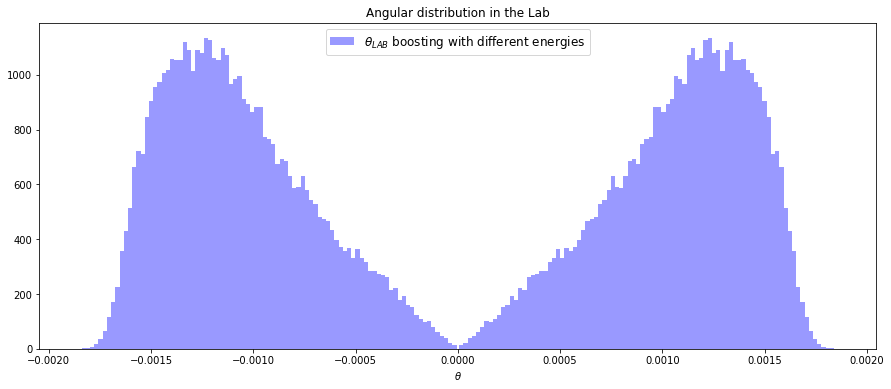

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(15,6))


ax.hist(theta_el,bins=binnumber, color='b',alpha=0.4,density=True,label='$\\theta_{LAB}$ boosting with different energies')
ax.hist(-theta_el,bins=binnumber, color='b',alpha=0.4,density=True)
ax.set_title("Angular distribution in the Lab")
ax.set_xlabel("$ \\theta$")



ax.legend(fontsize=12)
plt.show()

# 6. Babayaga simulation comparison <a class="anchor" id="Section.6"></a>
<div style="text-align: right"><a href="#Section.index">Return to index</a></div> 

[Babayaga](https://www2.pv.infn.it/~hepcomplex/babayaga.html) is an event generator based on relevant QED radiative corrections. For this simulation, we have used the BabayagaNLO package.

We made a comparison between our results and the output of the generator for the angle distribution (in the CoM) of the $\mu_-$ emission. The generation parameters (*input.txt*) are:
- Number of events = $10^7$
- Final state: $\mu^-\mu^+$
- CoM energy: $0.225 \ \mathrm{GeV}$
- $\theta_{\mathrm{min}}$  =    $0^\circ$
- $\theta_{\mathrm{max}}$   =    $180^\circ$
- Acollinearity: $10°$
- $E_{\mathrm{min}}$   =   $0.000 \ \mathrm{GeV}$
- ord    = exp    
- model  = matched   




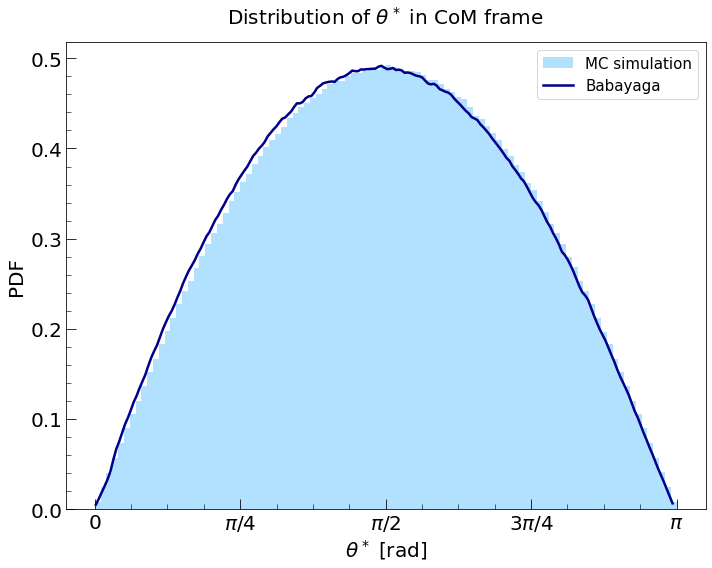

In [ ]:
babayaga_th = np.radians(np.loadtxt('matched_el_th_exp_200.txt').T)
theta_samples= np.loadtxt('angular_distribution_CM.txt')

fig, ax = plt.subplots(1, figsize = (10,8))

N_th, bins_th, _ = ax.hist(theta_samples, bins=100, density=True, label='MC simulation',color = '#009CFF',alpha = 0.3)
normalization    = np.max(babayaga_th[1])/np.max(N_th)

x_babayaga  = (babayaga_th[0][1:] + babayaga_th[0][:-1]) / 2
y_babayaga  = (babayaga_th[1][1:] + babayaga_th[1][:-1]) / 2 

ax.plot(x_babayaga, y_babayaga/normalization, linewidth=2.5, label='Babayaga', color = 'darkblue')

ax.set_title(r'Distribution of $\theta^*$ in CoM frame' ,fontsize = 20, pad = 18)
ax.set_xlabel(r'$\theta^*$ [rad]',fontsize = 20)
ax.set_ylabel('PDF',fontsize = 20)
ax.set_xticks([0,np.pi/4,np.pi/2,(3*np.pi)/4,np.pi],[0, '$\\pi/4$','$\\pi/2$','$3\\pi/4$','$\\pi$'])                   
ax.tick_params(axis = 'both', which = 'major', direction = 'in', length = 10, labelsize = 20)
ax.tick_params(axis = 'both', which = 'minor', direction = 'in', length = 5)
ax.minorticks_on()

ax.legend(loc='best', fontsize=15, ncol = 1)

fig.tight_layout()
plt.show()
#fig.savefig('figures/babayga.pdf')
